# SAE on Normal NN MNIST

Testing further on the 512 hidden size version.

Our default learned features definitely depend on "color". We can see this in our saliency plots of inverted images. Additionally, the sparse vector representations in both hidden layers change for an inverted image.

This might make it difficult to translate back our sparse vectors into meaningful digit representations, as pixel color is affecting feature space, instead of just digit shape. This might be problematic later for CIFAR...

But this just plies on with our current difficulty of getting meaning from sparse vectors...

**TODO:** try to use shapes of an image to generate sparse vectors and see saliency maps/if we can get a maximally activated sparse vector.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 512
L1_PENALTY = 0.3

## Imports

In [3]:
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cpu


## Load Data

In [7]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [8]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

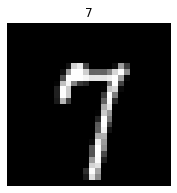

In [9]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [11]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [13]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]


### SAE

In [14]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [15]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [16]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [17]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [18]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [19]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [20]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [21]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [22]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

Epoch 1/20
  Train Loss: 1.0131
  SAE Train Loss (hidden one): 8.9857
  SAE Train Loss (hidden two): 1.4461
  Val Loss: 0.5521 | Val Acc: 83.76%
  Saved model with Val Acc: 83.76%


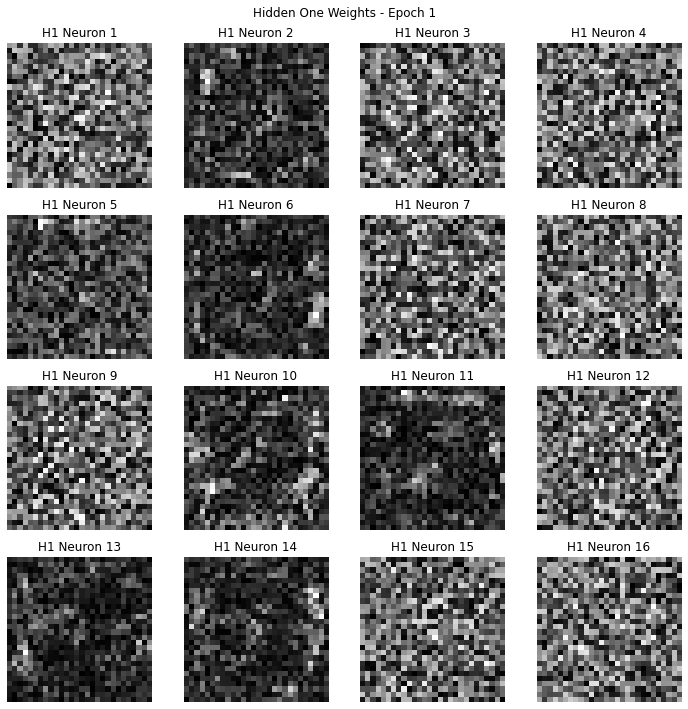

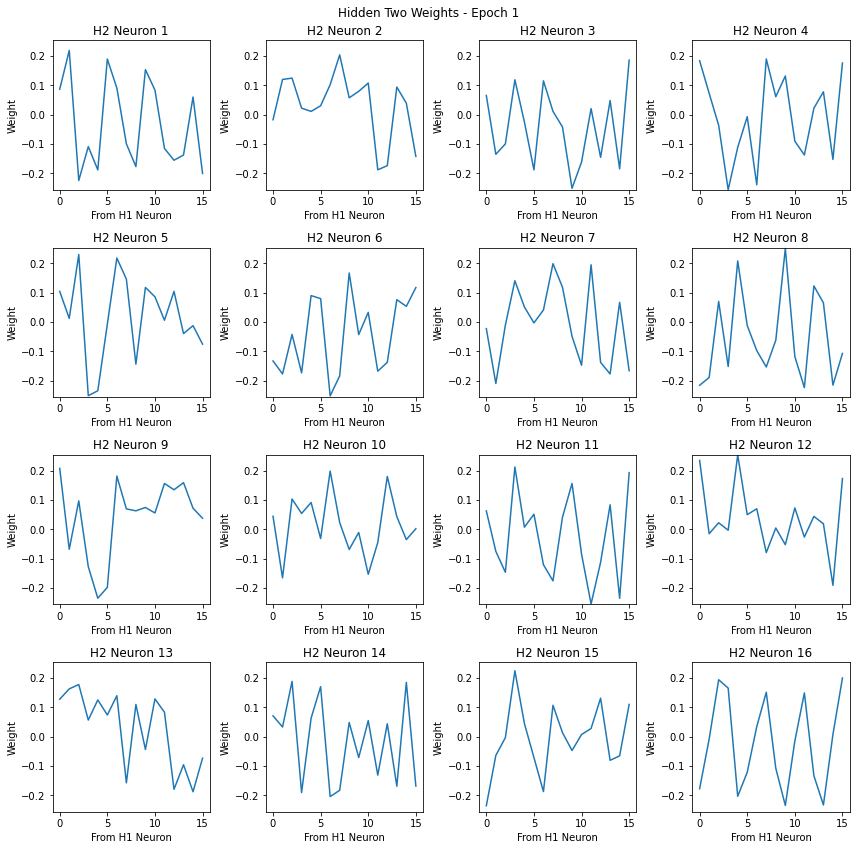

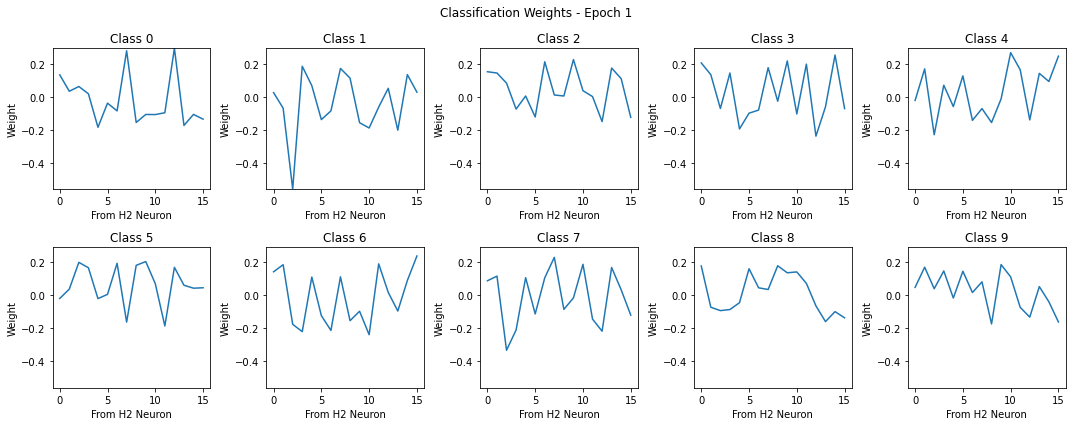

Epoch 2/20
  Train Loss: 0.4601
  SAE Train Loss (hidden one): 2.9089
  SAE Train Loss (hidden two): 0.4892
  Val Loss: 0.4512 | Val Acc: 86.42%
  Saved model with Val Acc: 86.42%


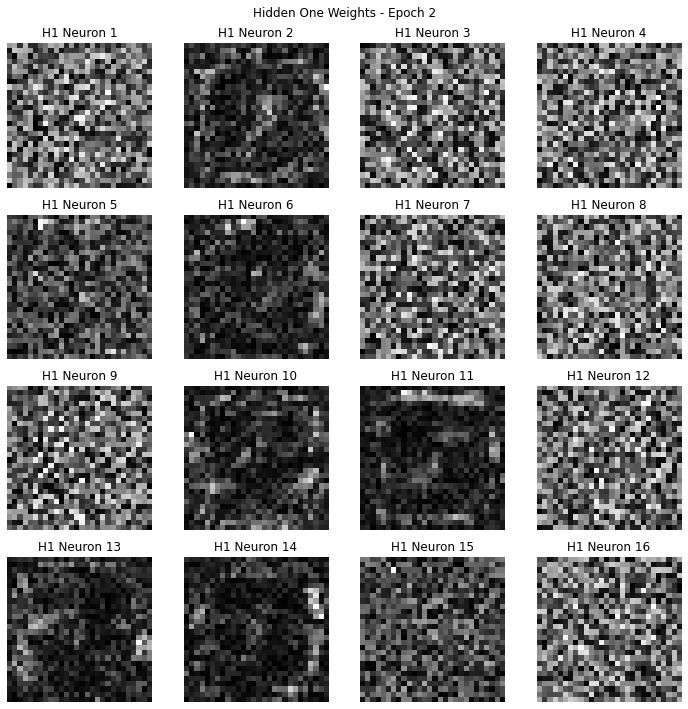

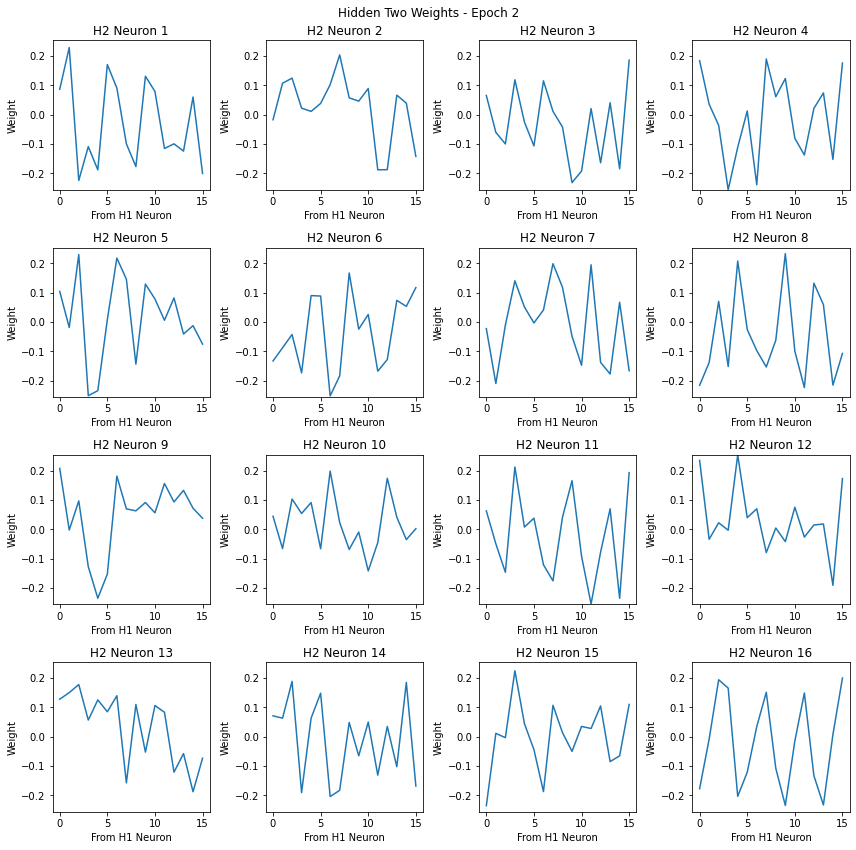

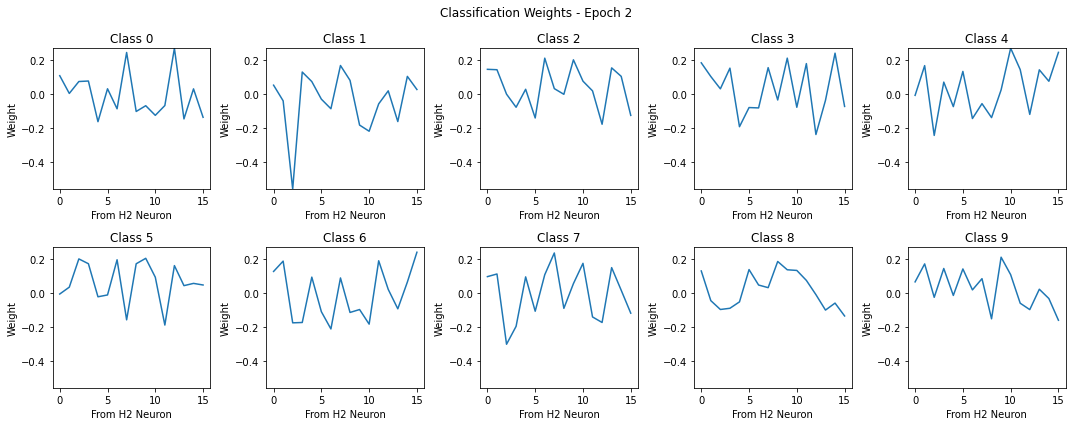

Epoch 3/20
  Train Loss: 0.4093
  SAE Train Loss (hidden one): 2.4353
  SAE Train Loss (hidden two): 0.3319
  Val Loss: 0.4022 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


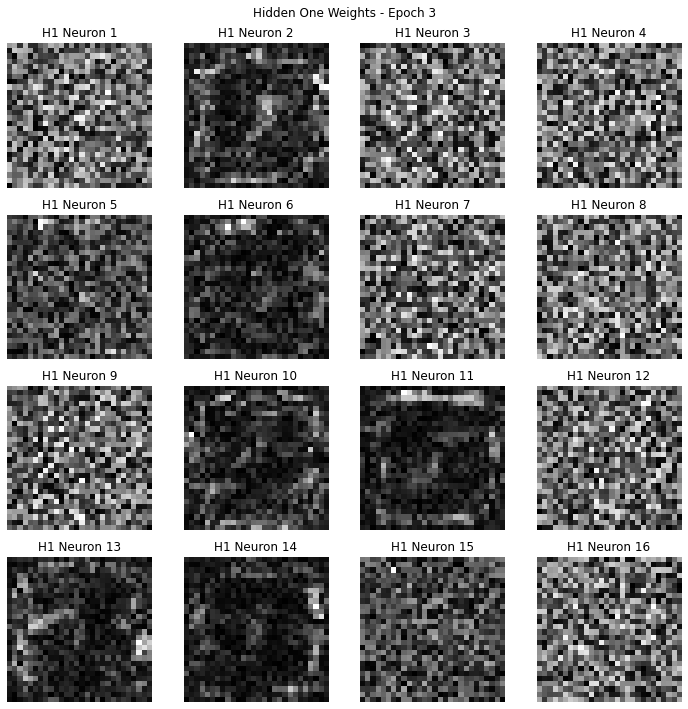

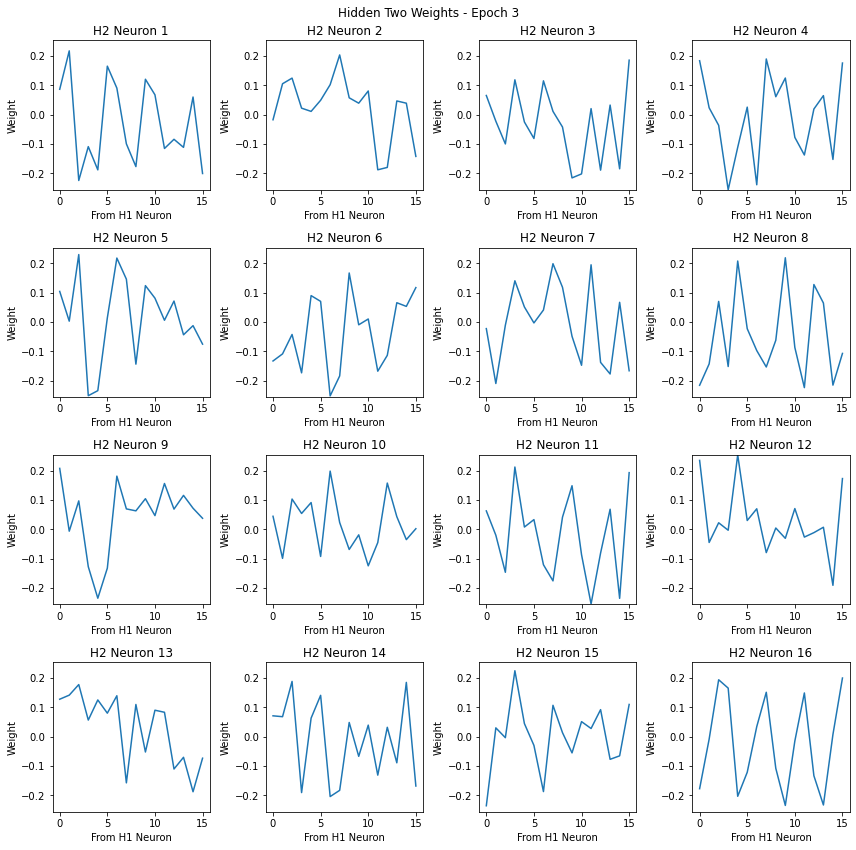

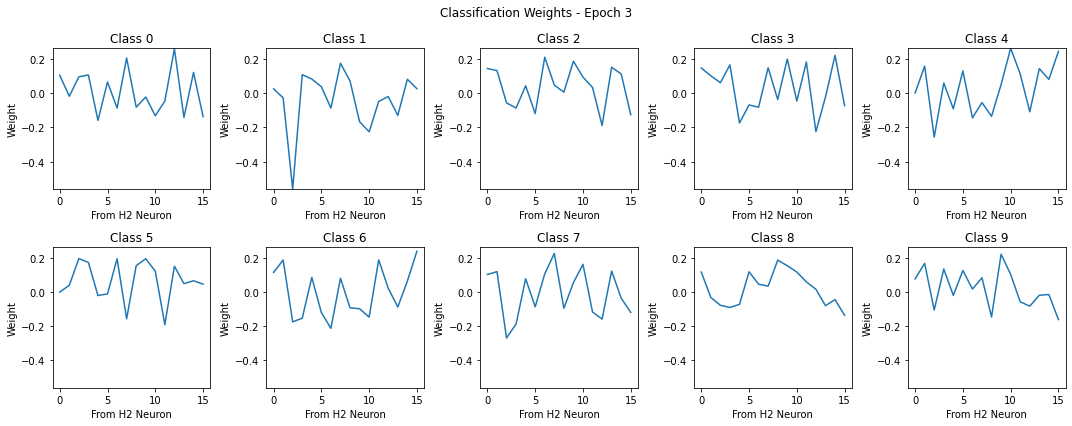

Epoch 4/20
  Train Loss: 0.3899
  SAE Train Loss (hidden one): 2.1690
  SAE Train Loss (hidden two): 0.2680
  Val Loss: 0.4044 | Val Acc: 87.80%
  Saved model with Val Acc: 87.80%


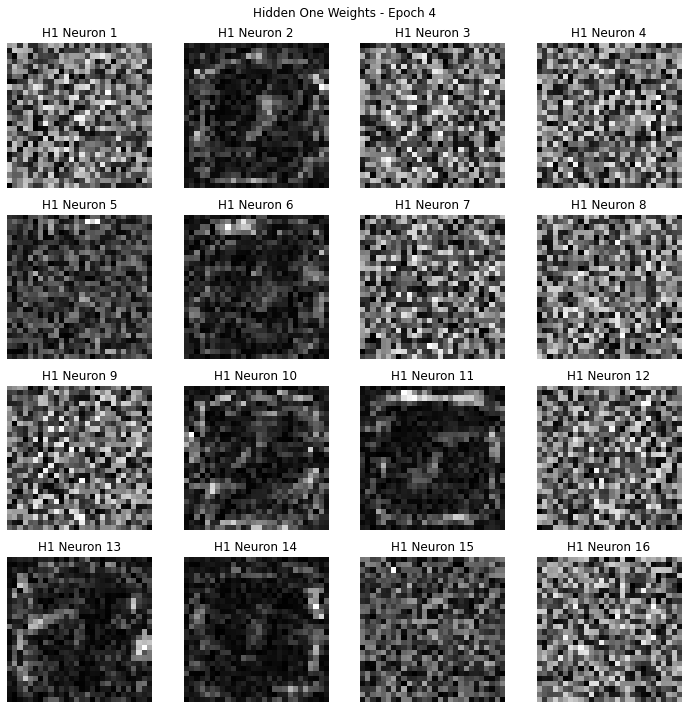

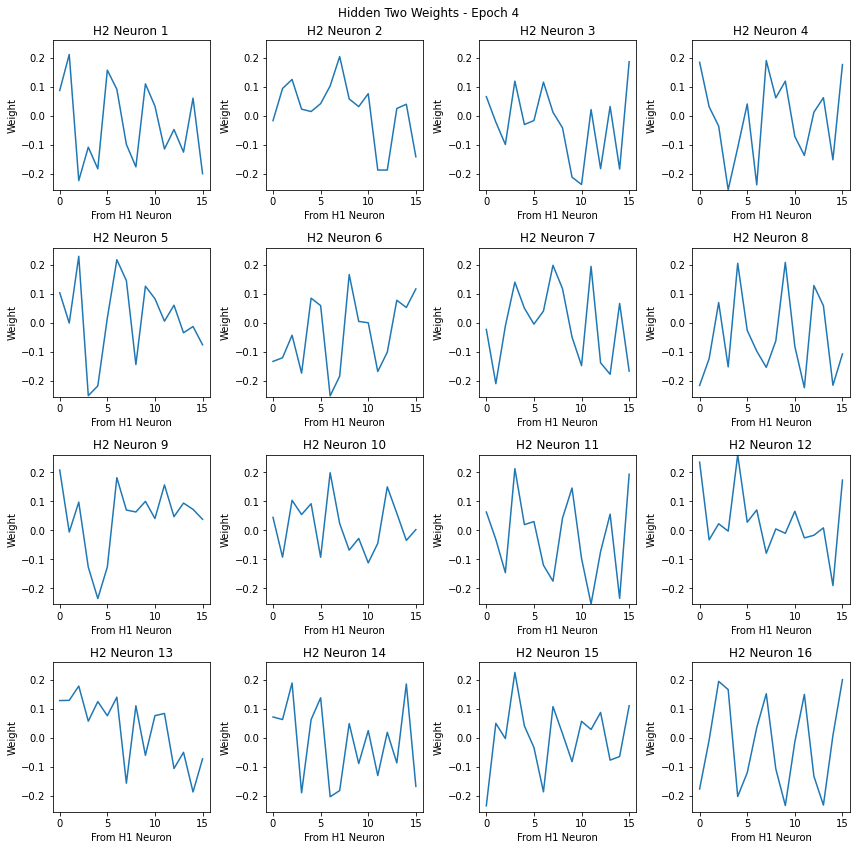

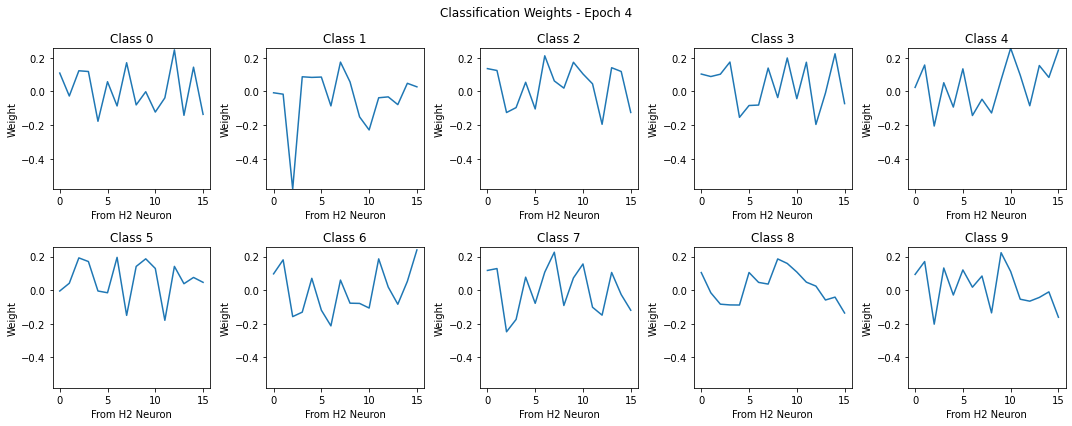

Epoch 5/20
  Train Loss: 0.3708
  SAE Train Loss (hidden one): 2.0194
  SAE Train Loss (hidden two): 0.2389
  Val Loss: 0.3718 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


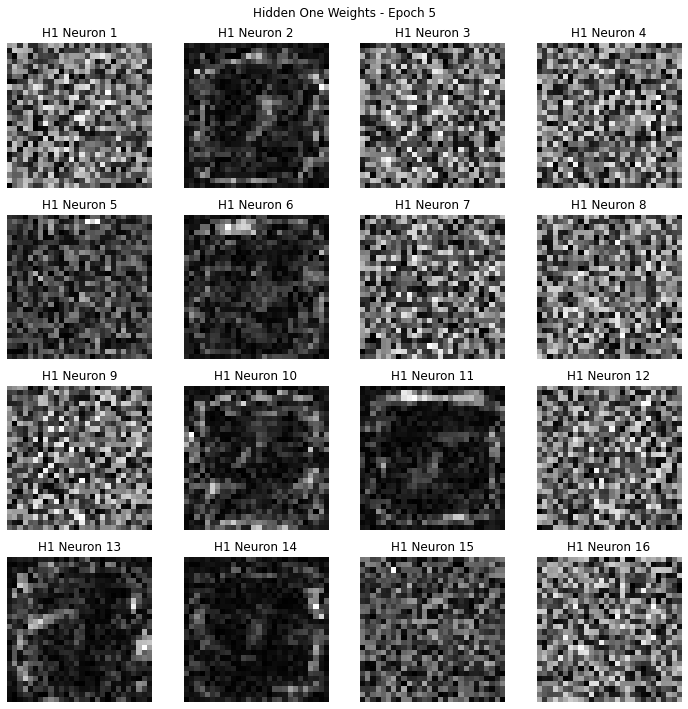

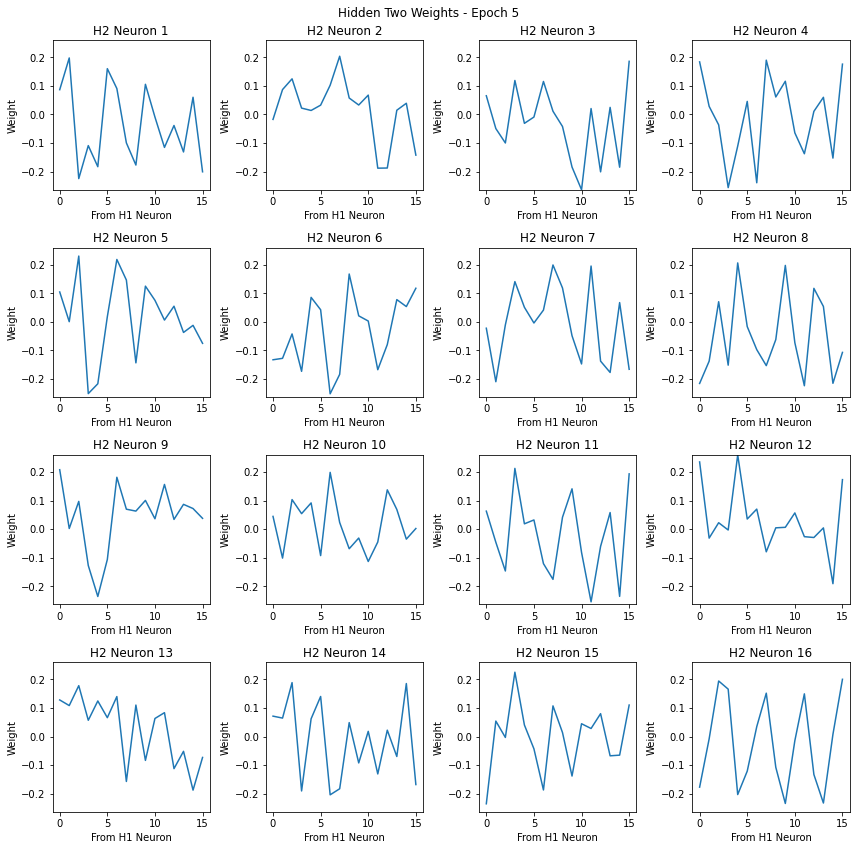

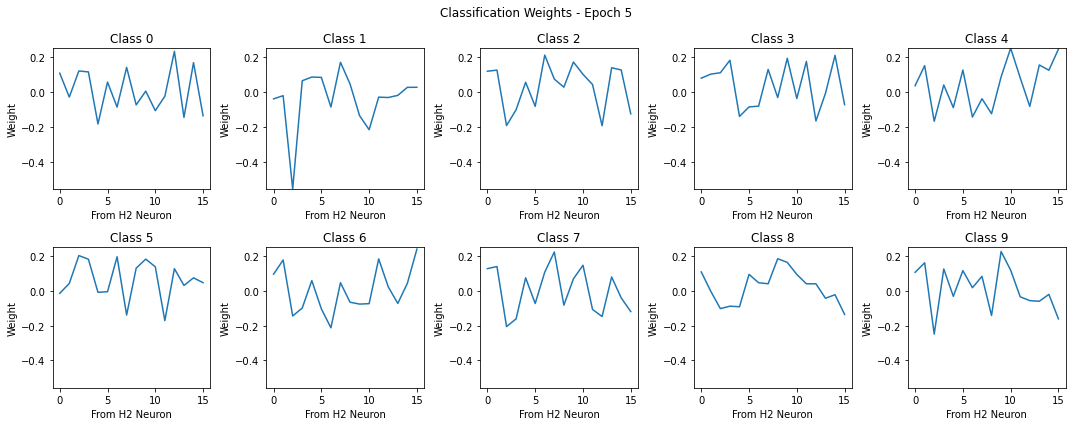

Epoch 6/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 1.9192
  SAE Train Loss (hidden two): 0.2164
  Val Loss: 0.3640 | Val Acc: 89.51%
  Saved model with Val Acc: 89.51%


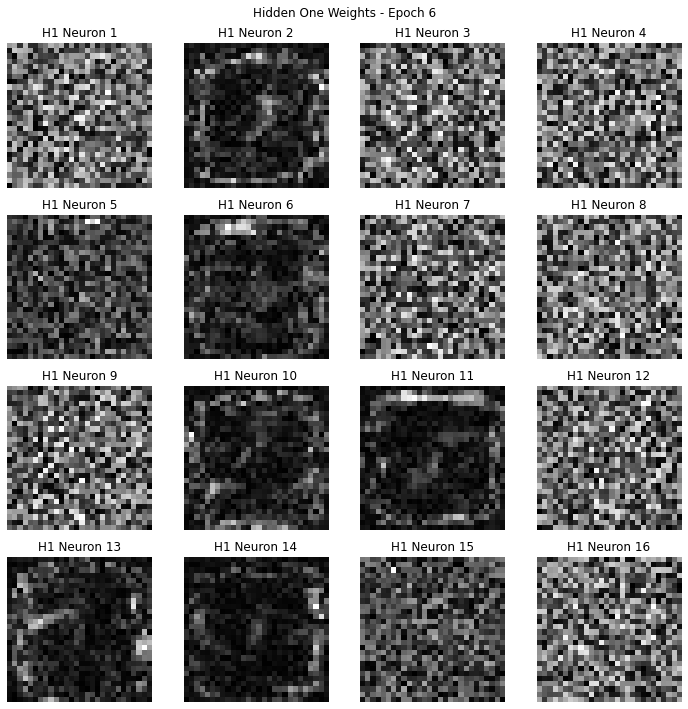

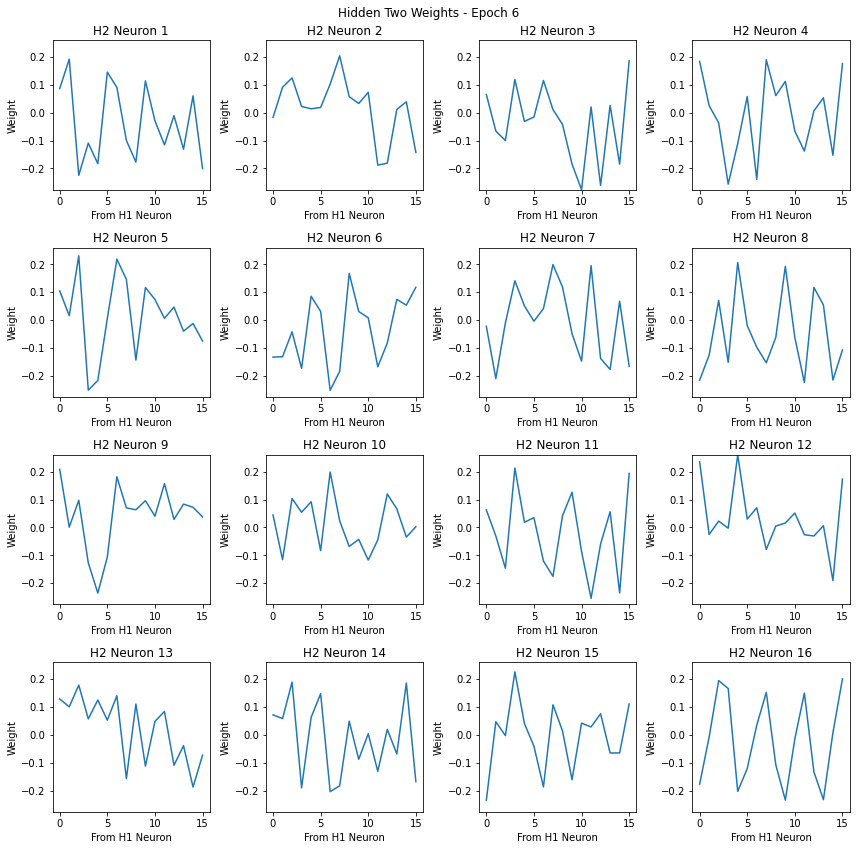

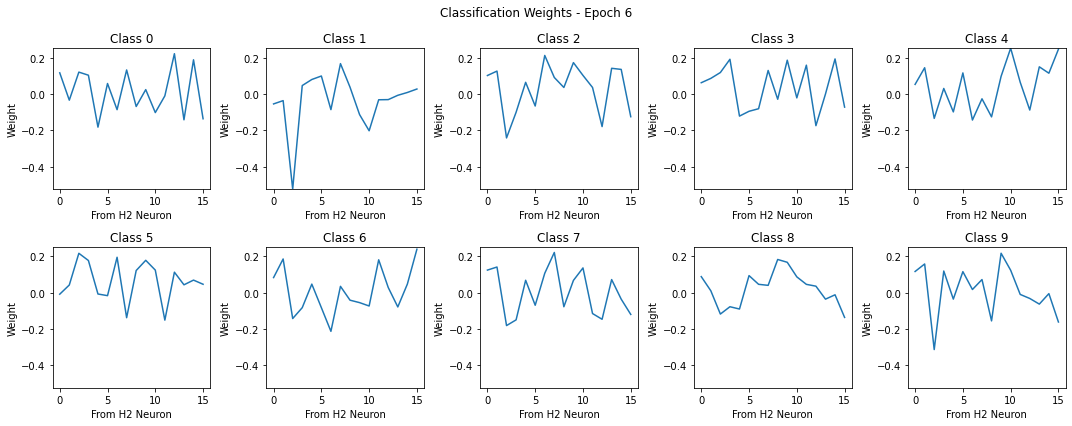

Epoch 7/20
  Train Loss: 0.3511
  SAE Train Loss (hidden one): 1.8450
  SAE Train Loss (hidden two): 0.2028
  Val Loss: 0.3932 | Val Acc: 88.37%


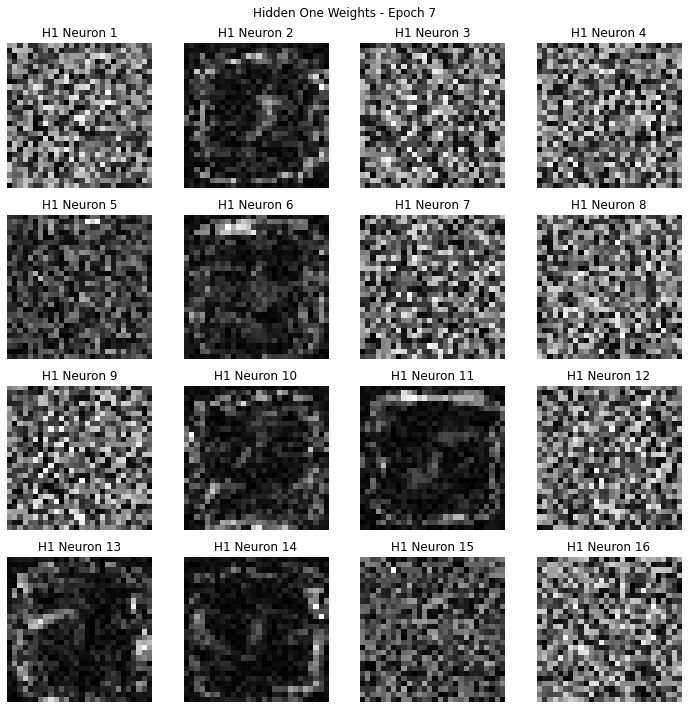

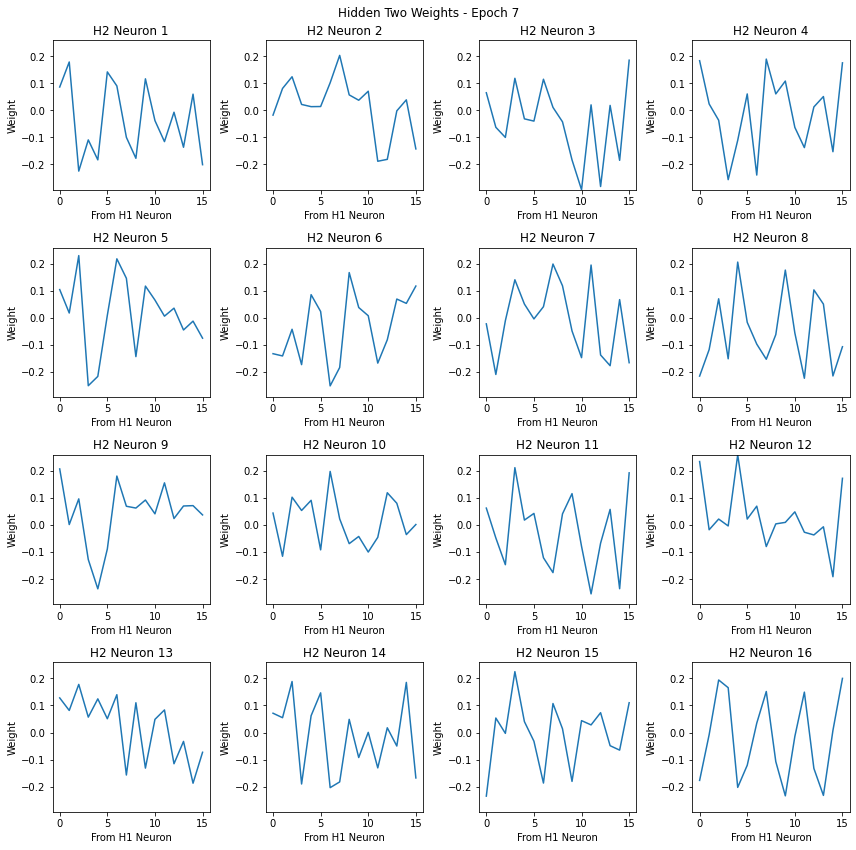

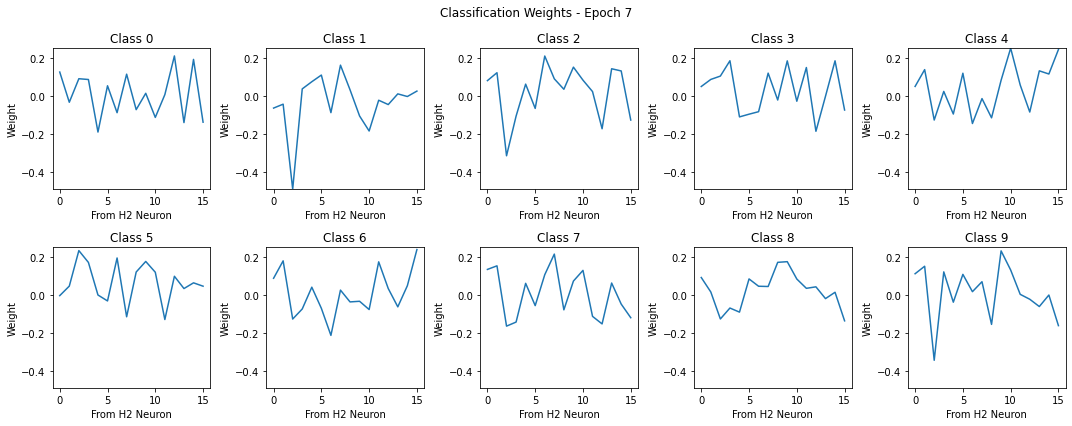

Epoch 8/20
  Train Loss: 0.3440
  SAE Train Loss (hidden one): 1.8085
  SAE Train Loss (hidden two): 0.1912
  Val Loss: 0.3642 | Val Acc: 89.00%


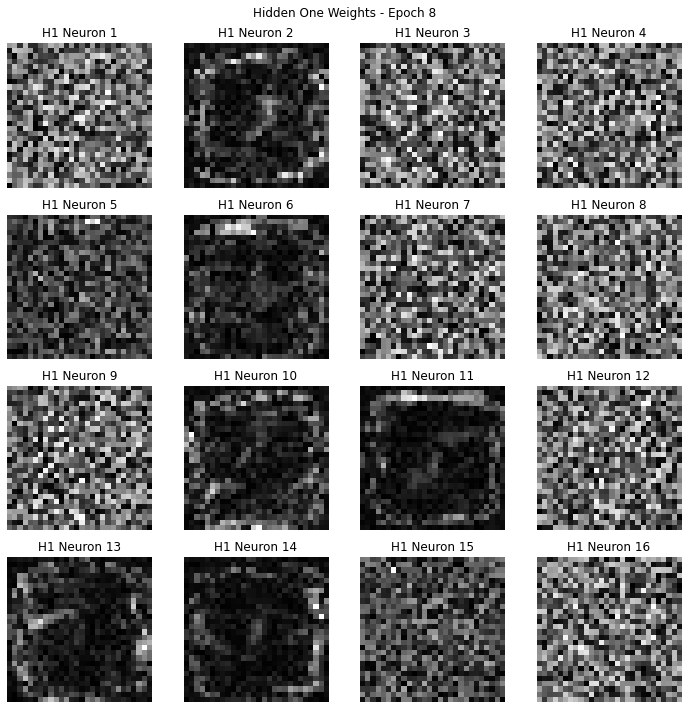

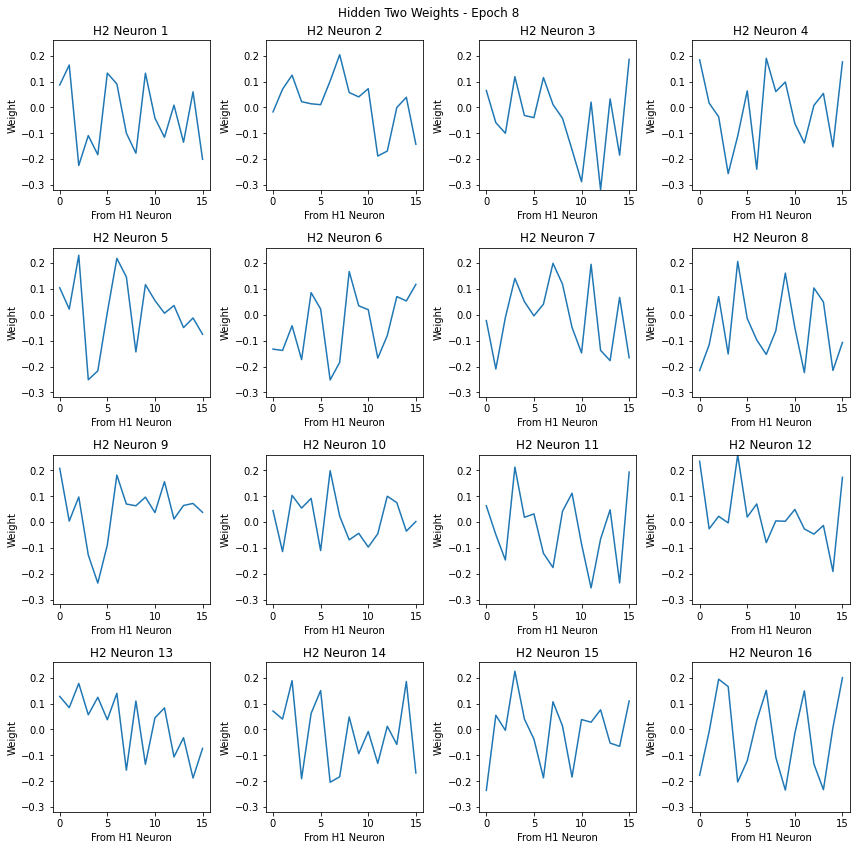

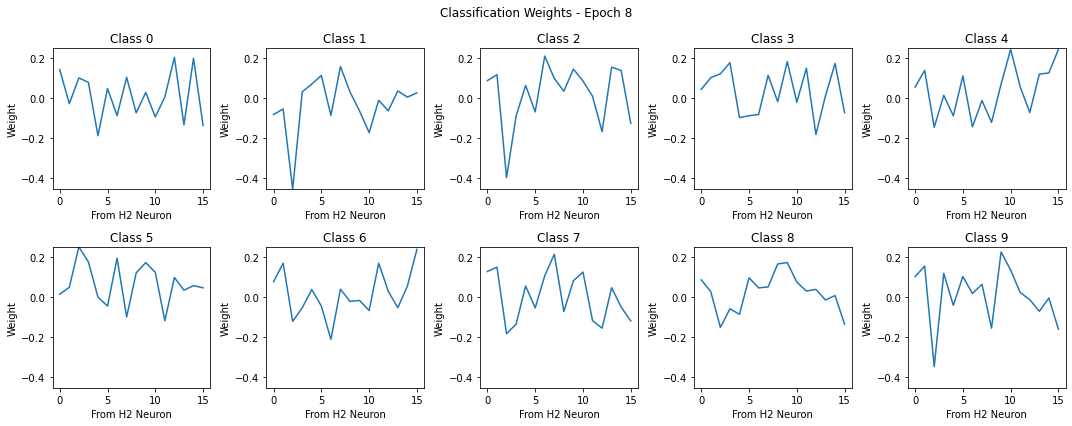

Epoch 9/20
  Train Loss: 0.3392
  SAE Train Loss (hidden one): 1.7735
  SAE Train Loss (hidden two): 0.1841
  Val Loss: 0.3668 | Val Acc: 89.01%


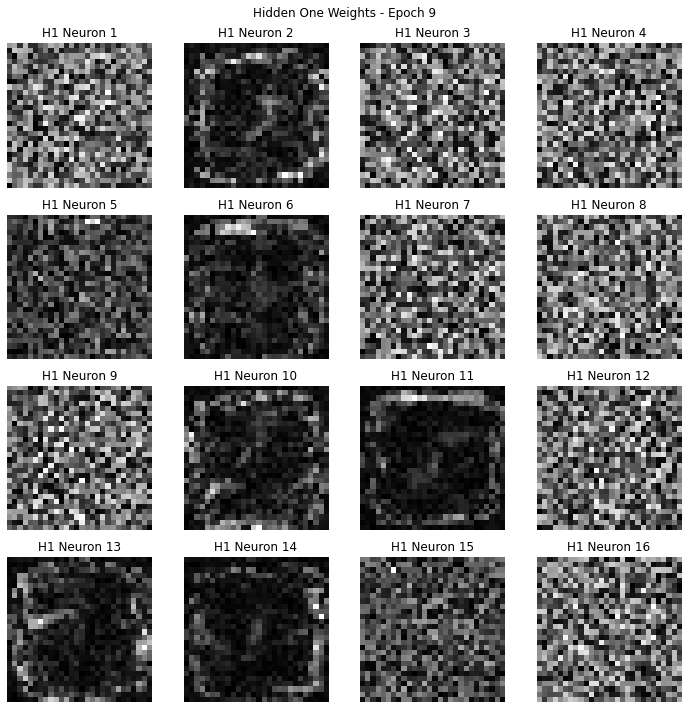

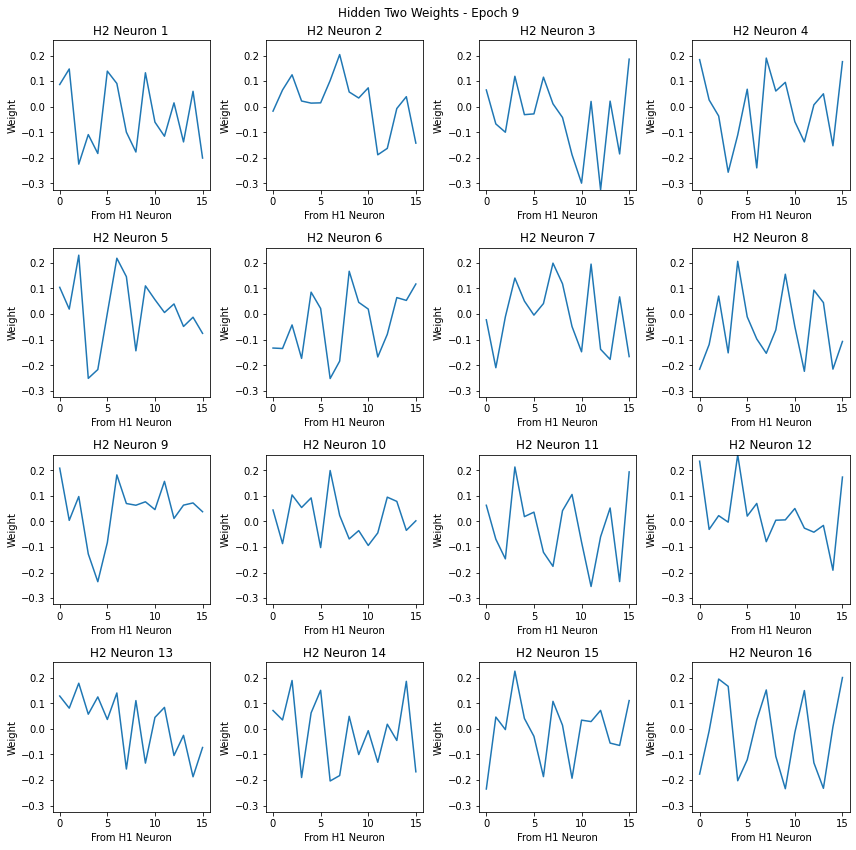

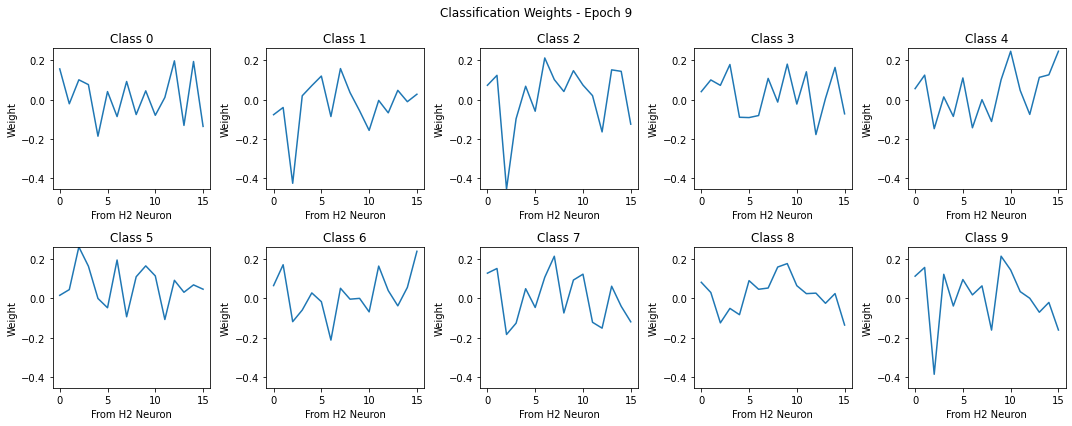

Epoch 10/20
  Train Loss: 0.3337
  SAE Train Loss (hidden one): 1.7759
  SAE Train Loss (hidden two): 0.1734
  Val Loss: 0.3616 | Val Acc: 89.52%
  Saved model with Val Acc: 89.52%


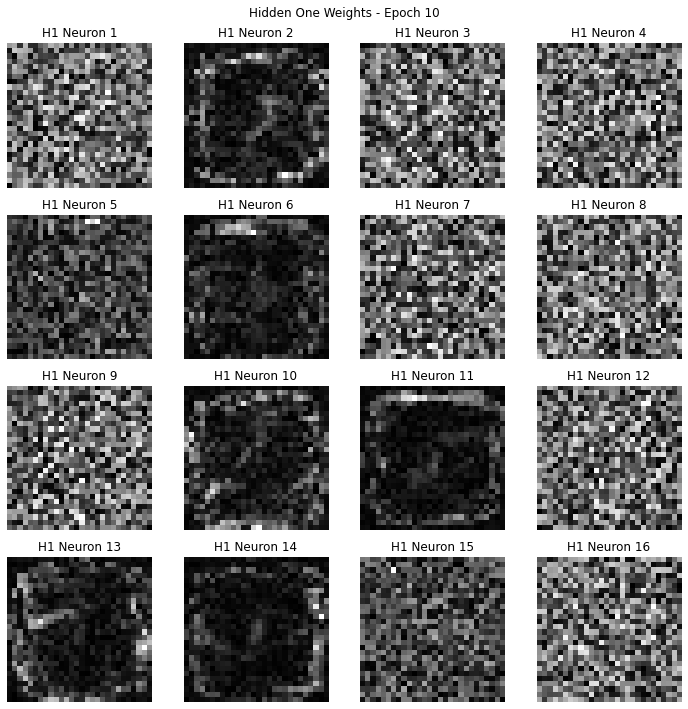

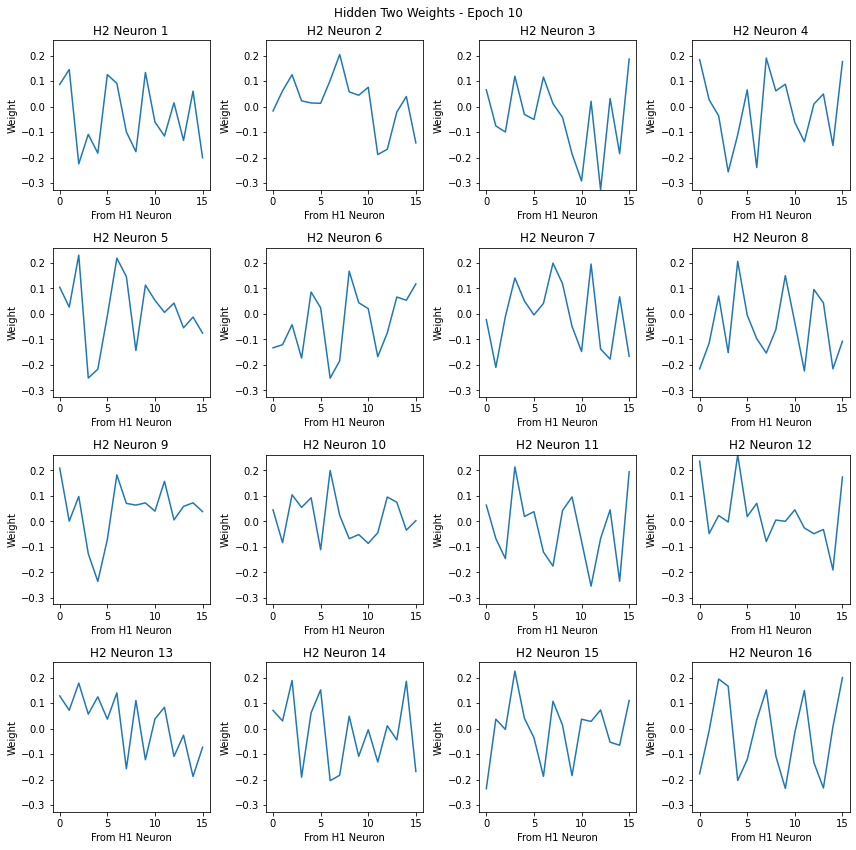

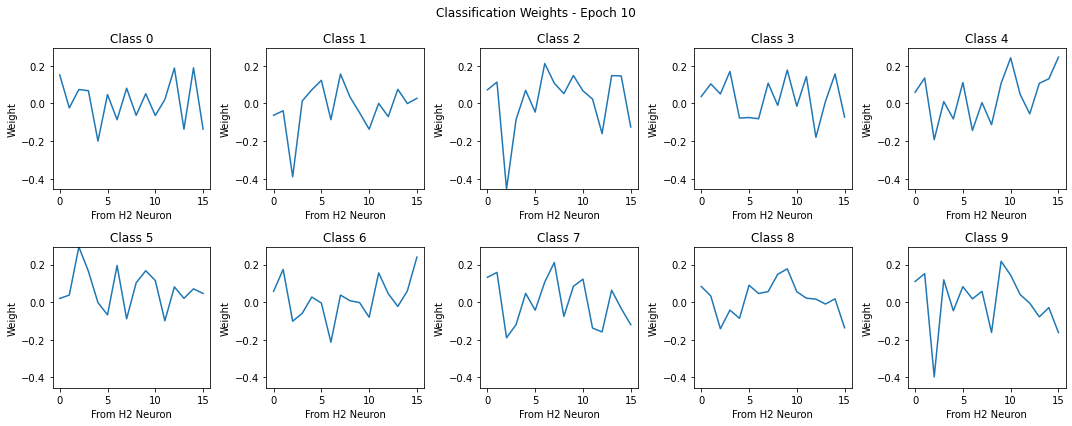

Epoch 11/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 1.7494
  SAE Train Loss (hidden two): 0.1688
  Val Loss: 0.3636 | Val Acc: 89.26%


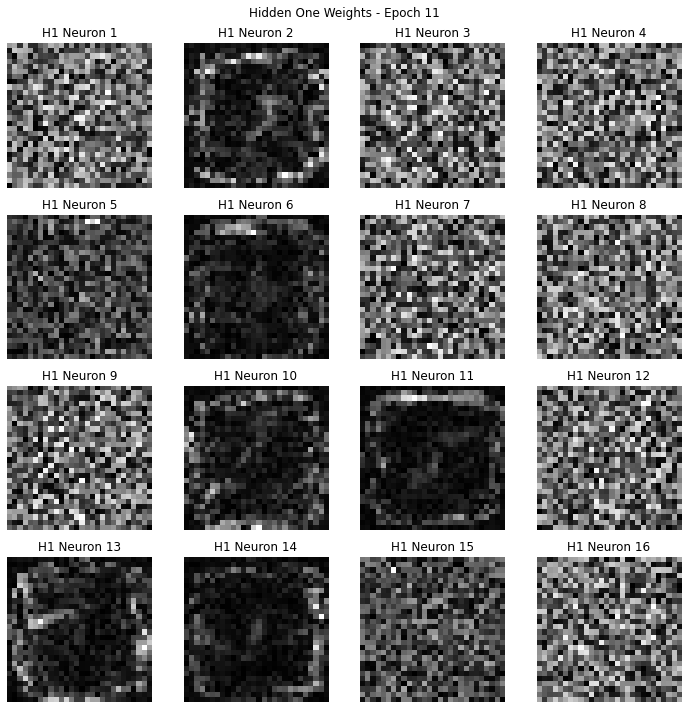

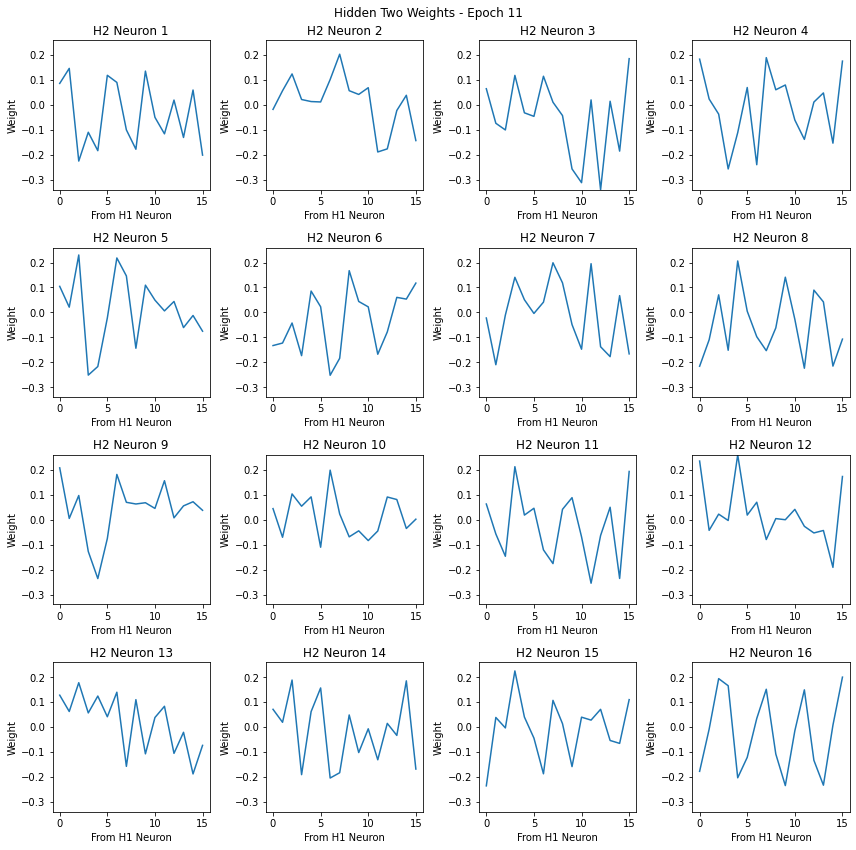

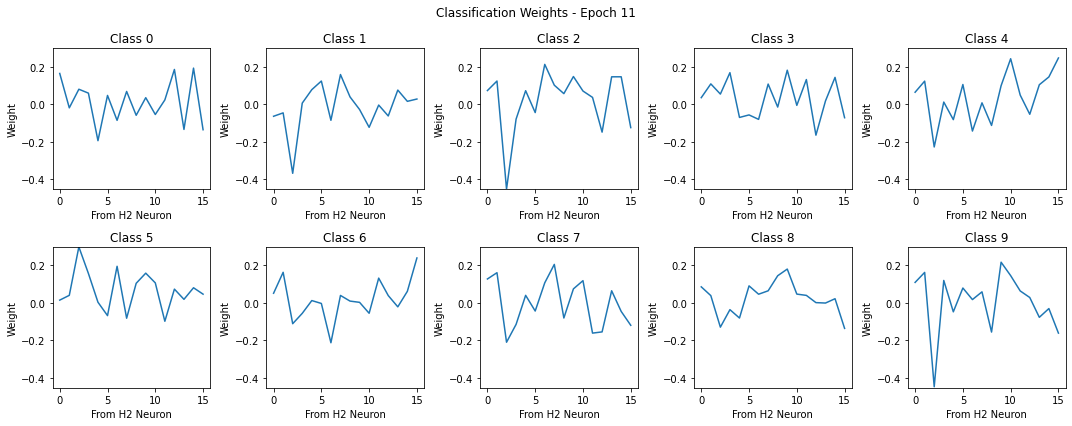

Epoch 12/20
  Train Loss: 0.3276
  SAE Train Loss (hidden one): 1.7420
  SAE Train Loss (hidden two): 0.1603
  Val Loss: 0.3588 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


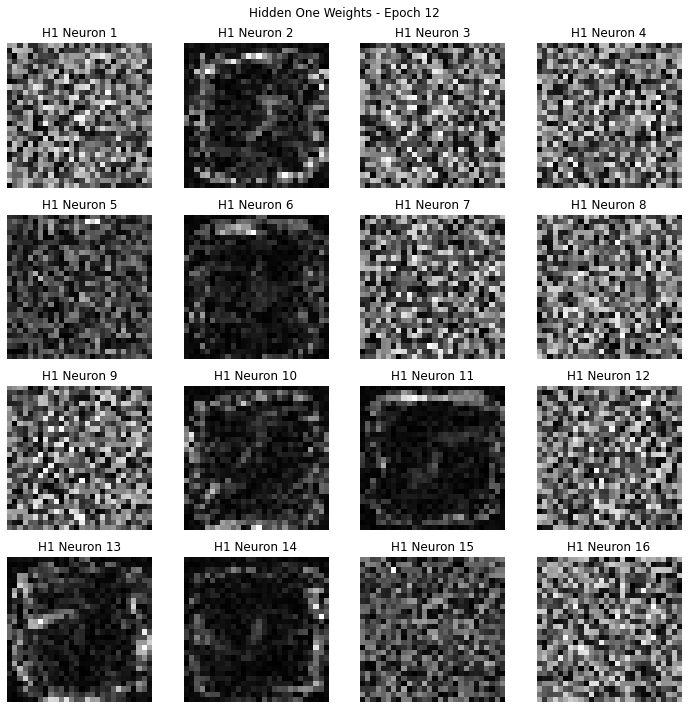

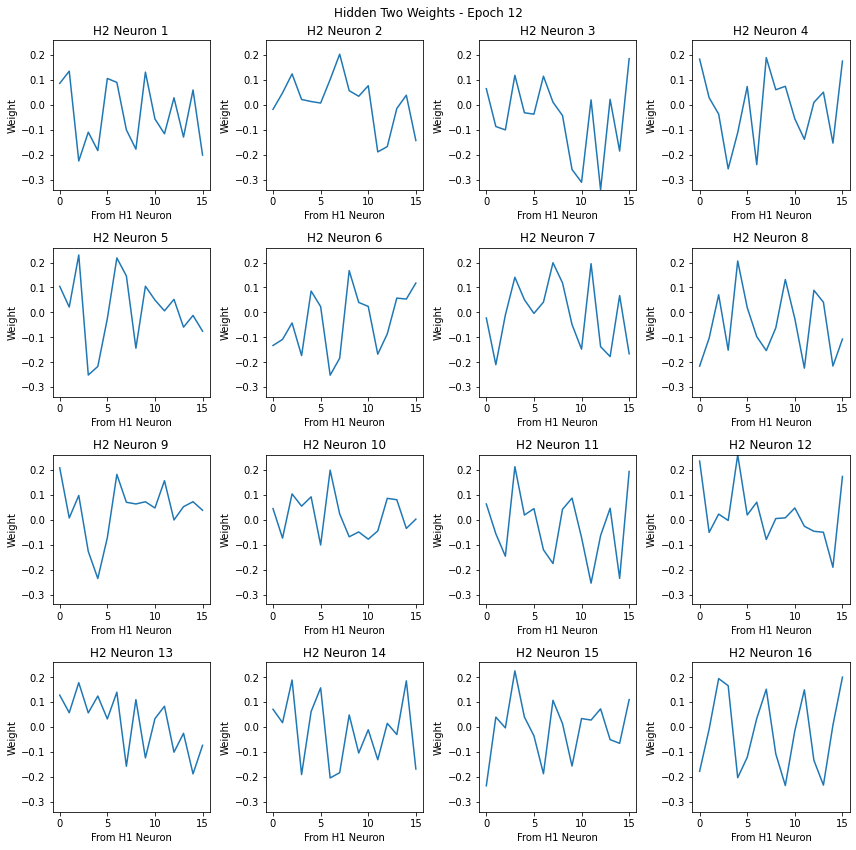

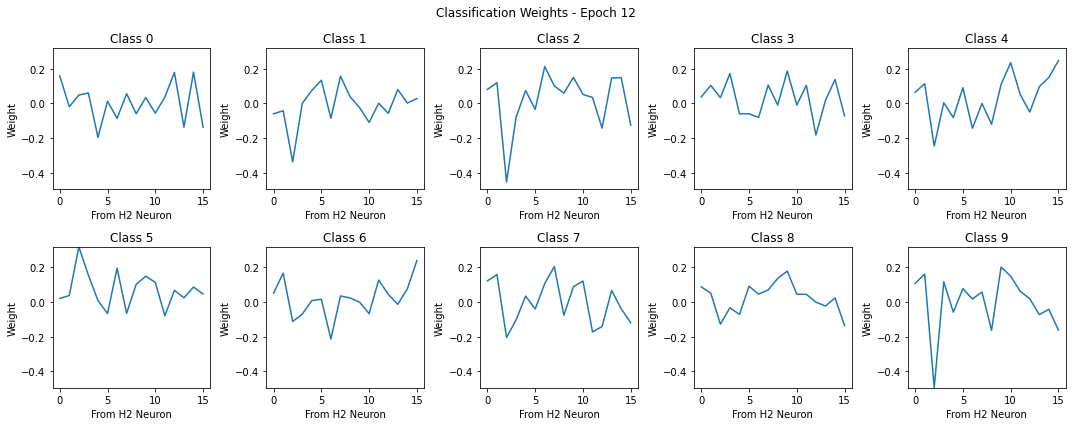

Epoch 13/20
  Train Loss: 0.3246
  SAE Train Loss (hidden one): 1.7059
  SAE Train Loss (hidden two): 0.1535
  Val Loss: 0.3596 | Val Acc: 89.44%


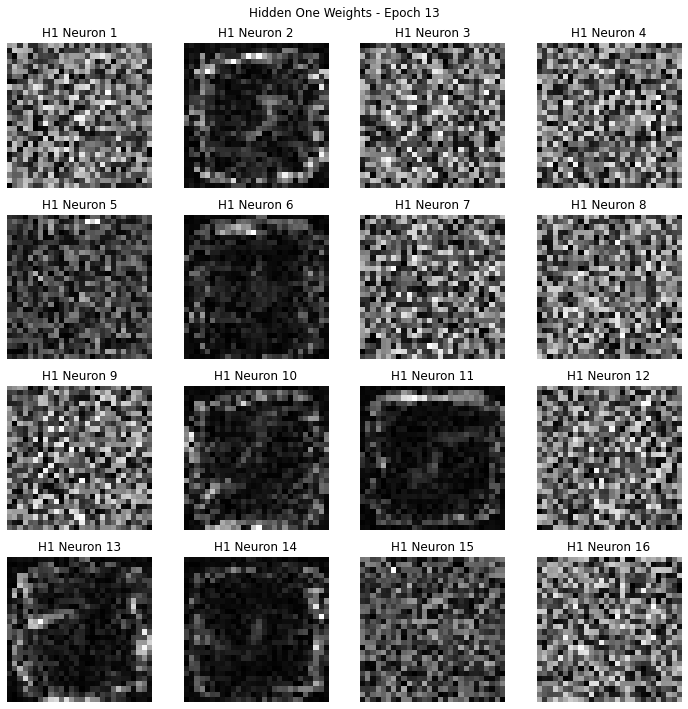

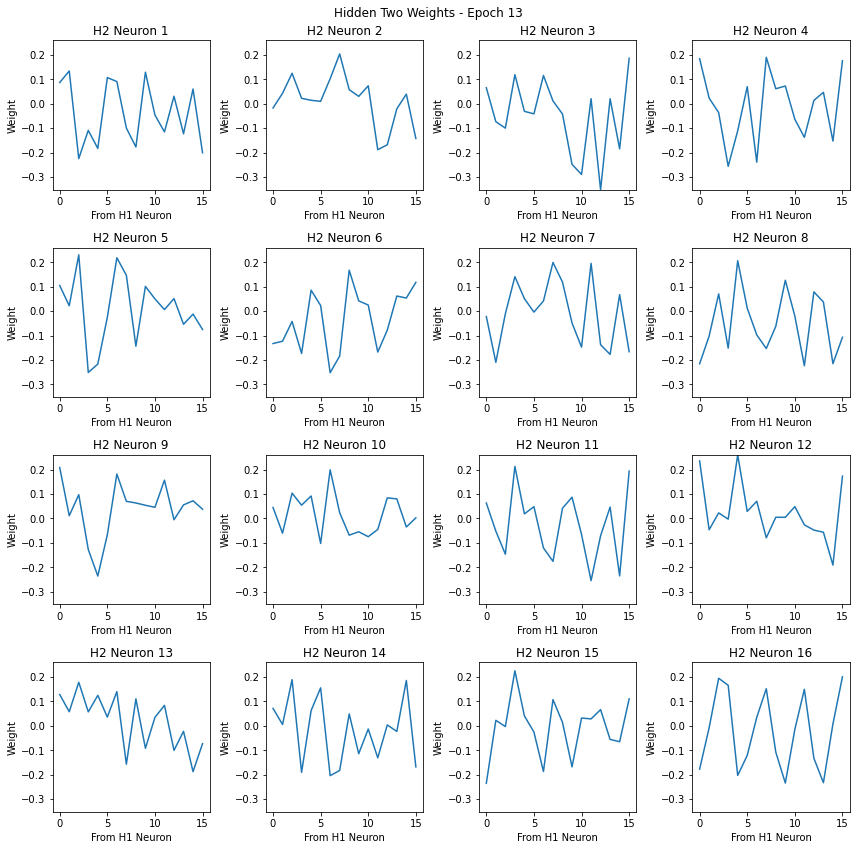

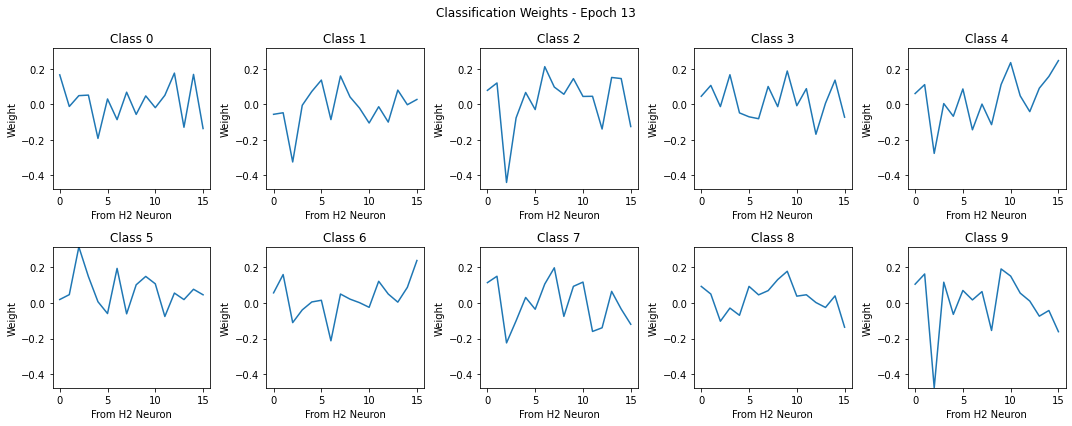

Epoch 14/20
  Train Loss: 0.3221
  SAE Train Loss (hidden one): 1.6948
  SAE Train Loss (hidden two): 0.1447
  Val Loss: 0.3644 | Val Acc: 89.28%


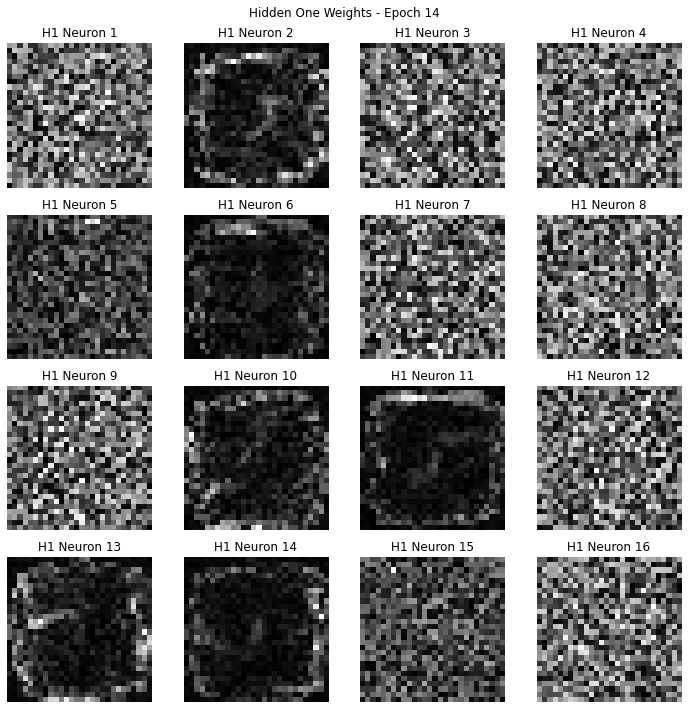

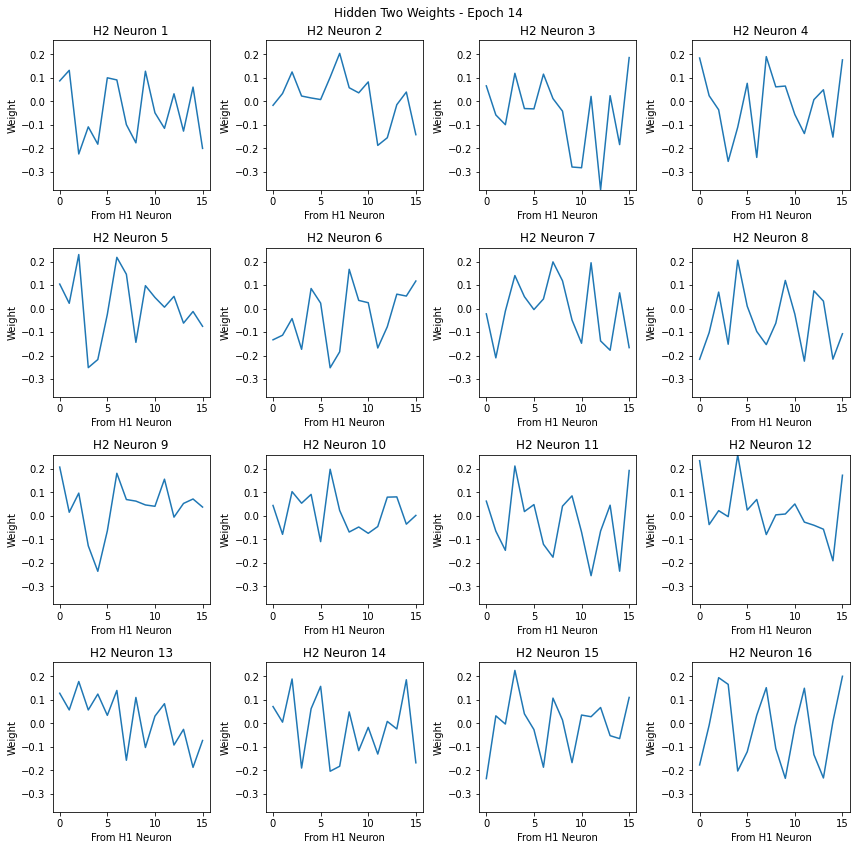

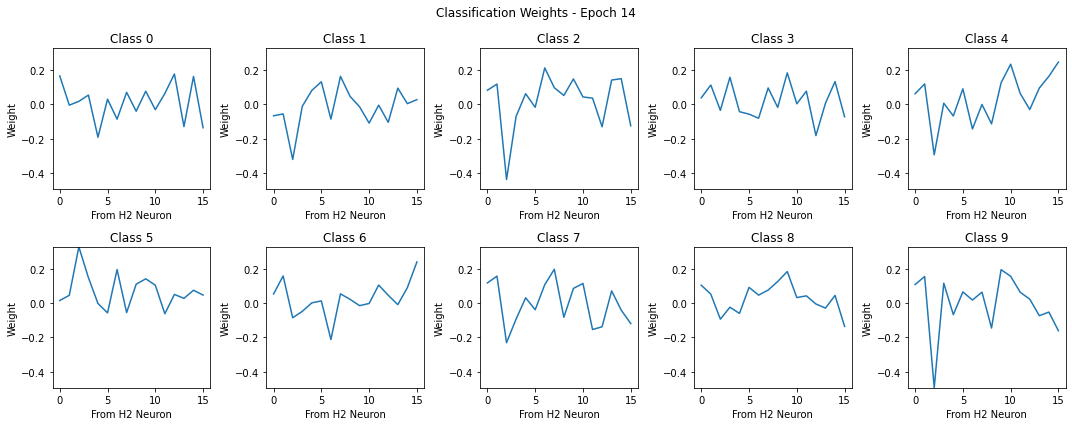

Epoch 15/20
  Train Loss: 0.3212
  SAE Train Loss (hidden one): 1.6390
  SAE Train Loss (hidden two): 0.1377
  Val Loss: 0.3651 | Val Acc: 89.16%


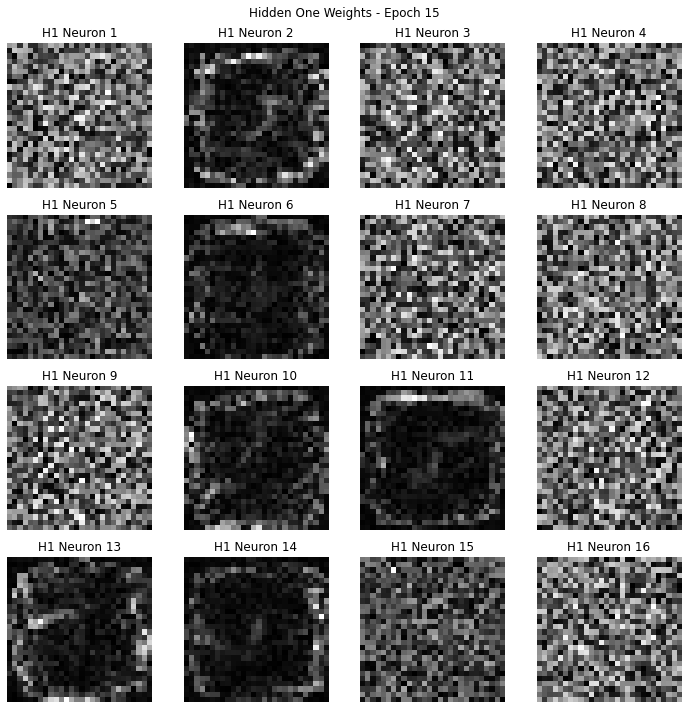

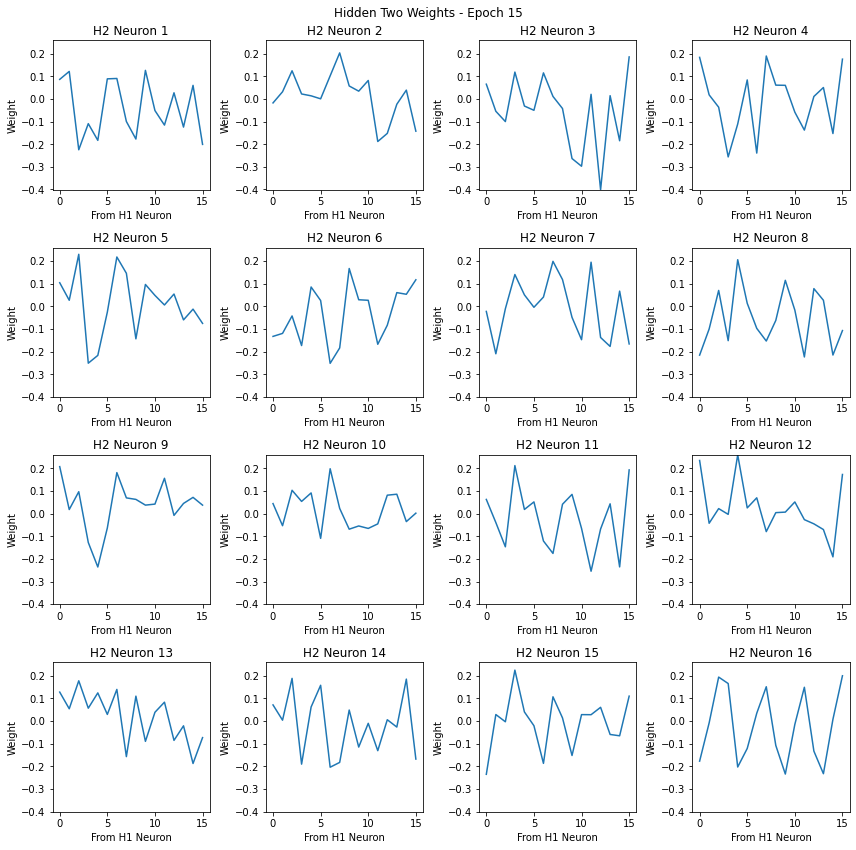

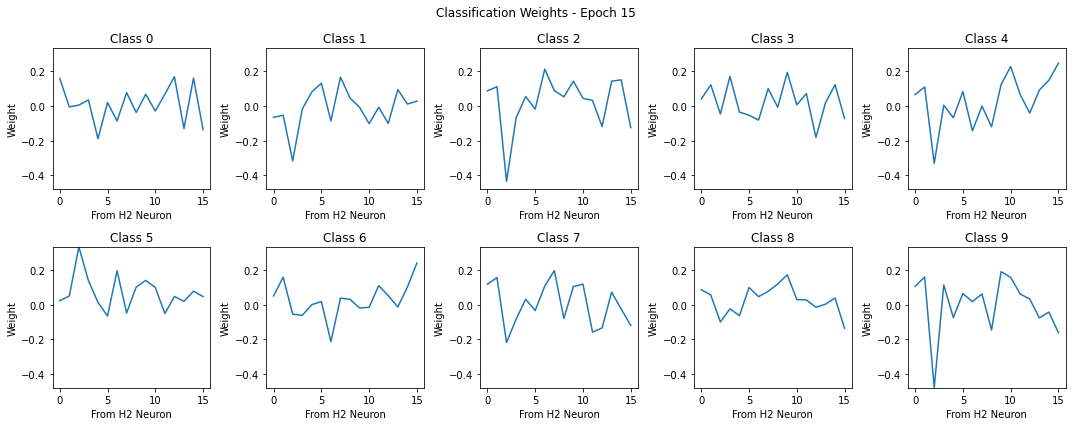

Epoch 16/20
  Train Loss: 0.3165
  SAE Train Loss (hidden one): 1.7006
  SAE Train Loss (hidden two): 0.1343
  Val Loss: 0.3507 | Val Acc: 89.55%
  Saved model with Val Acc: 89.55%


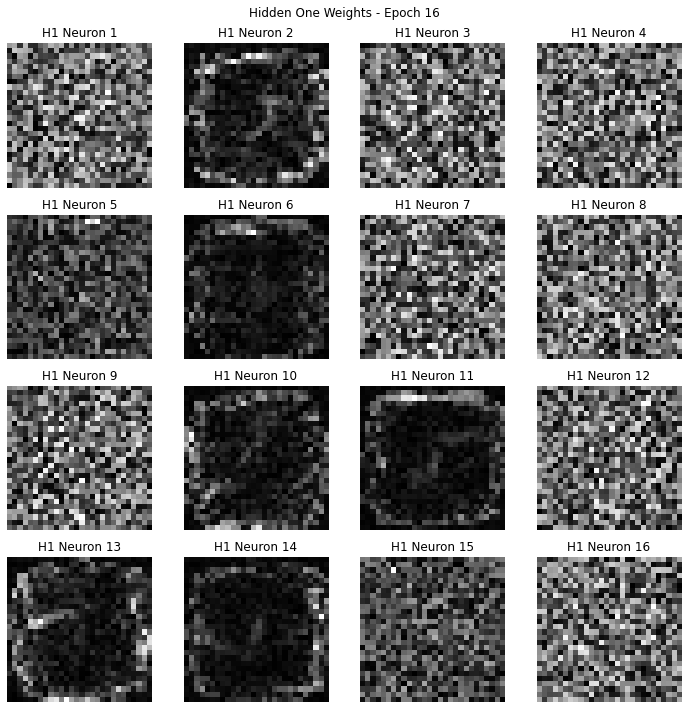

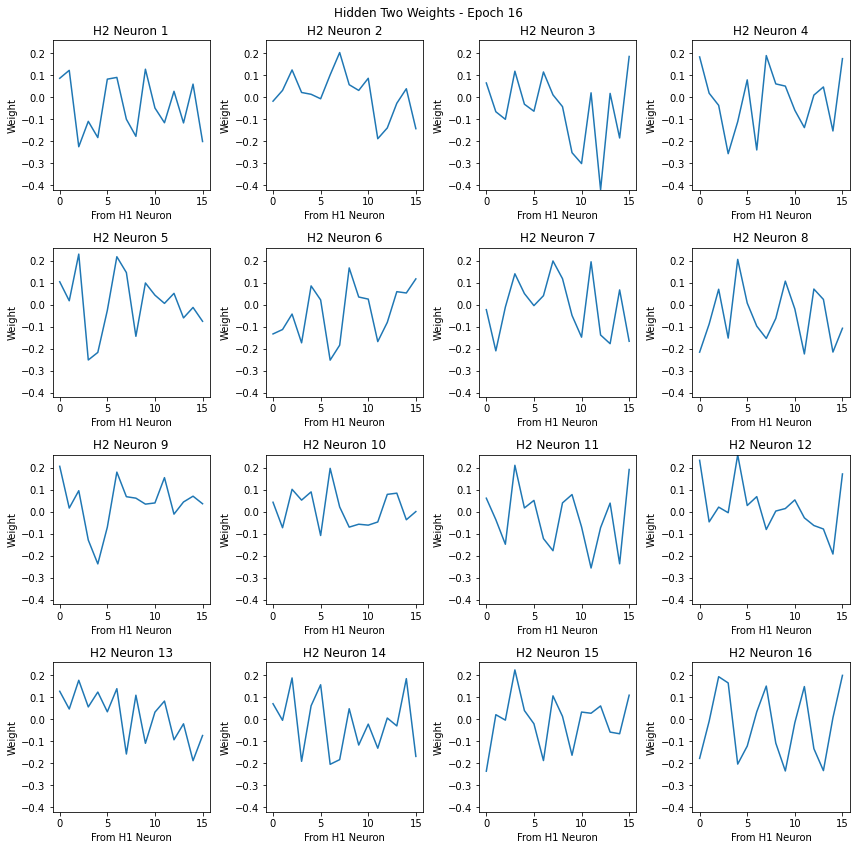

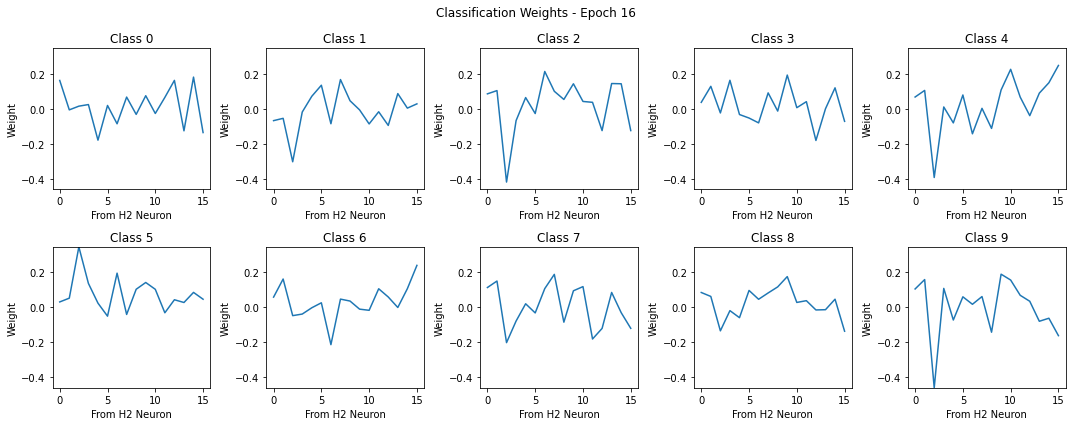

Epoch 17/20
  Train Loss: 0.3181
  SAE Train Loss (hidden one): 1.7546
  SAE Train Loss (hidden two): 0.1286
  Val Loss: 0.3458 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


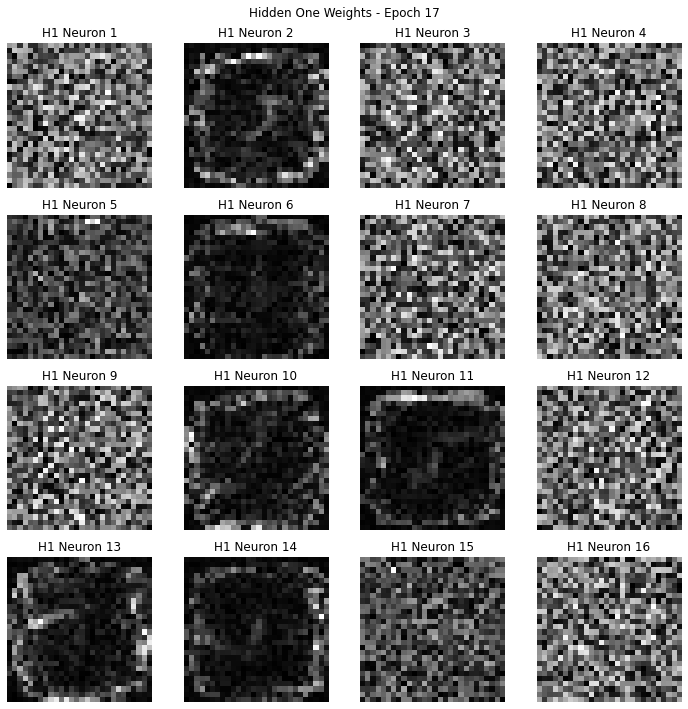

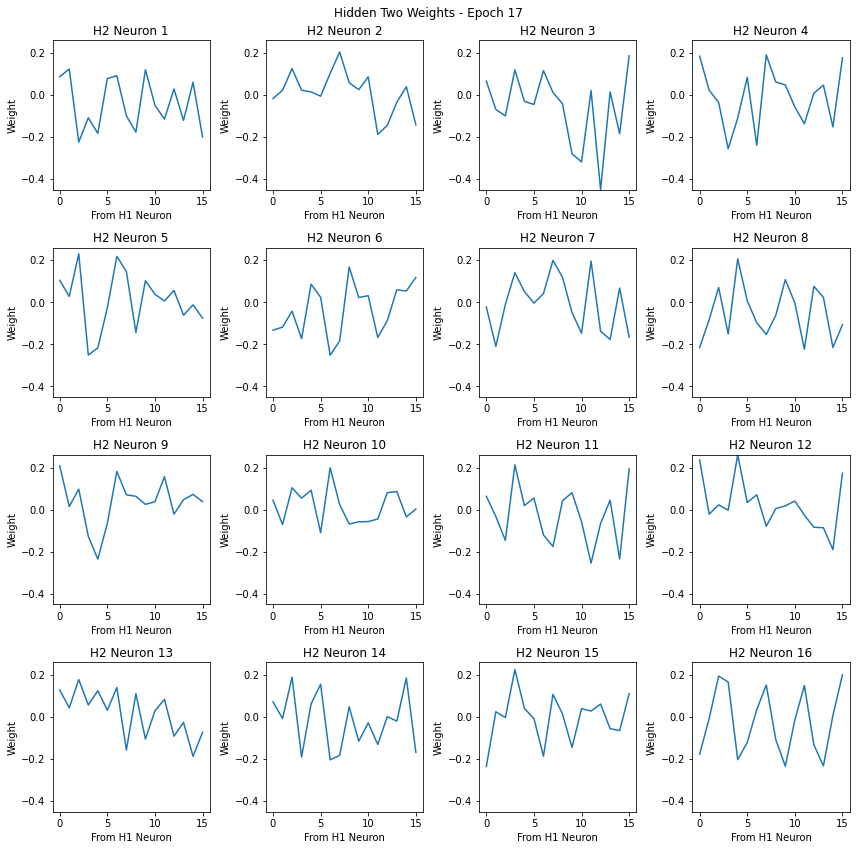

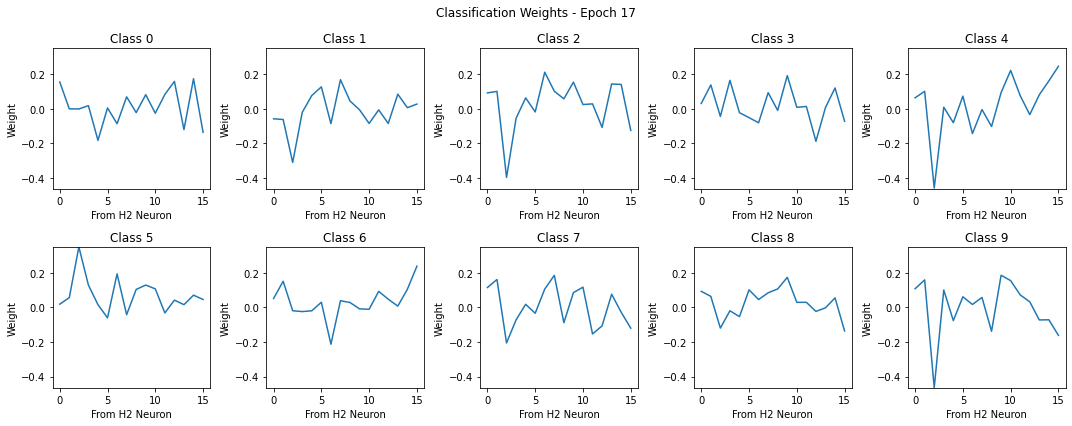

Epoch 18/20
  Train Loss: 0.3160
  SAE Train Loss (hidden one): 1.6351
  SAE Train Loss (hidden two): 0.1211
  Val Loss: 0.3437 | Val Acc: 89.84%


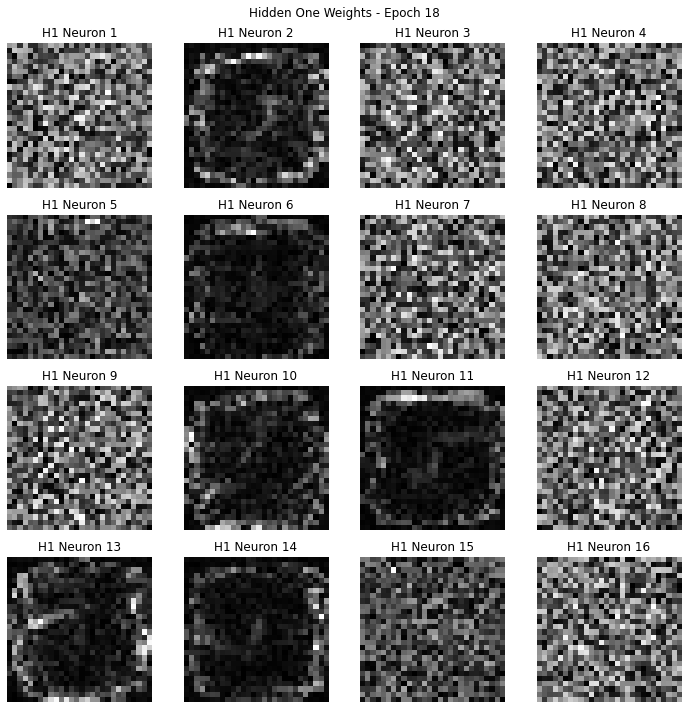

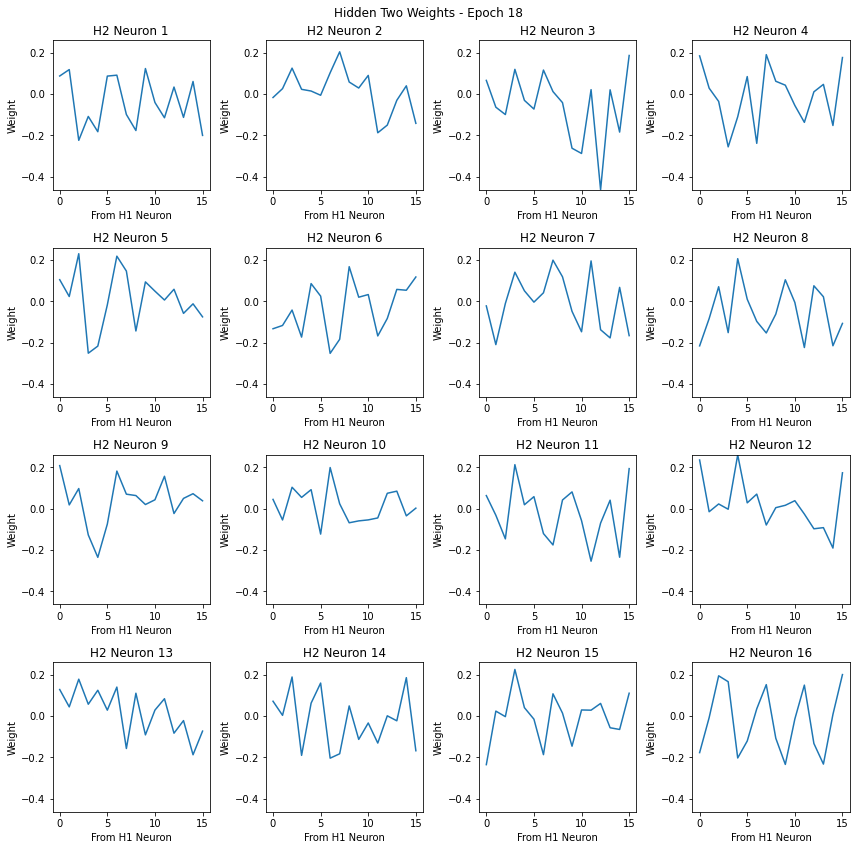

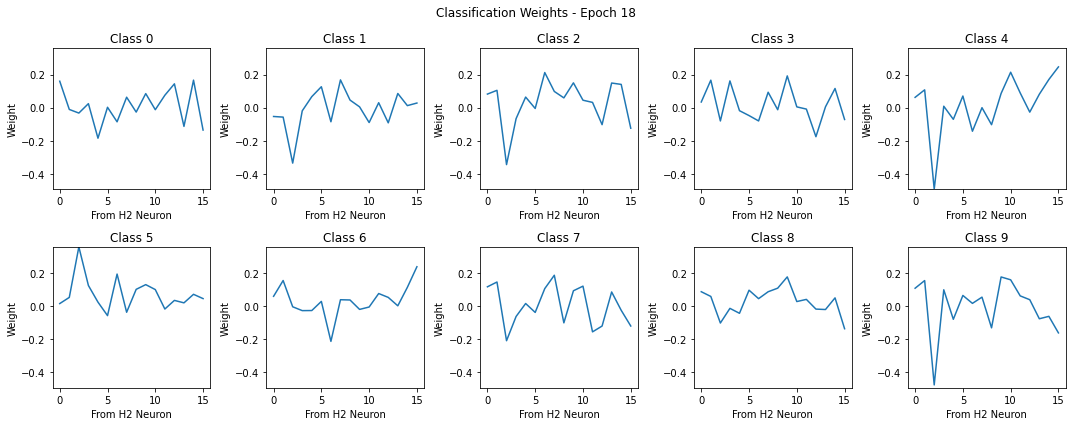

Epoch 19/20
  Train Loss: 0.3143
  SAE Train Loss (hidden one): 1.8010
  SAE Train Loss (hidden two): 0.1187
  Val Loss: 0.3601 | Val Acc: 89.45%


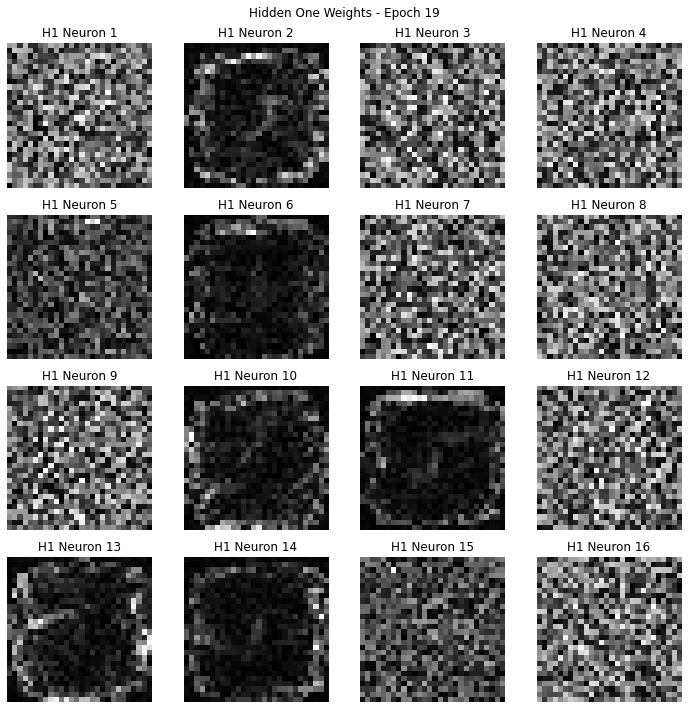

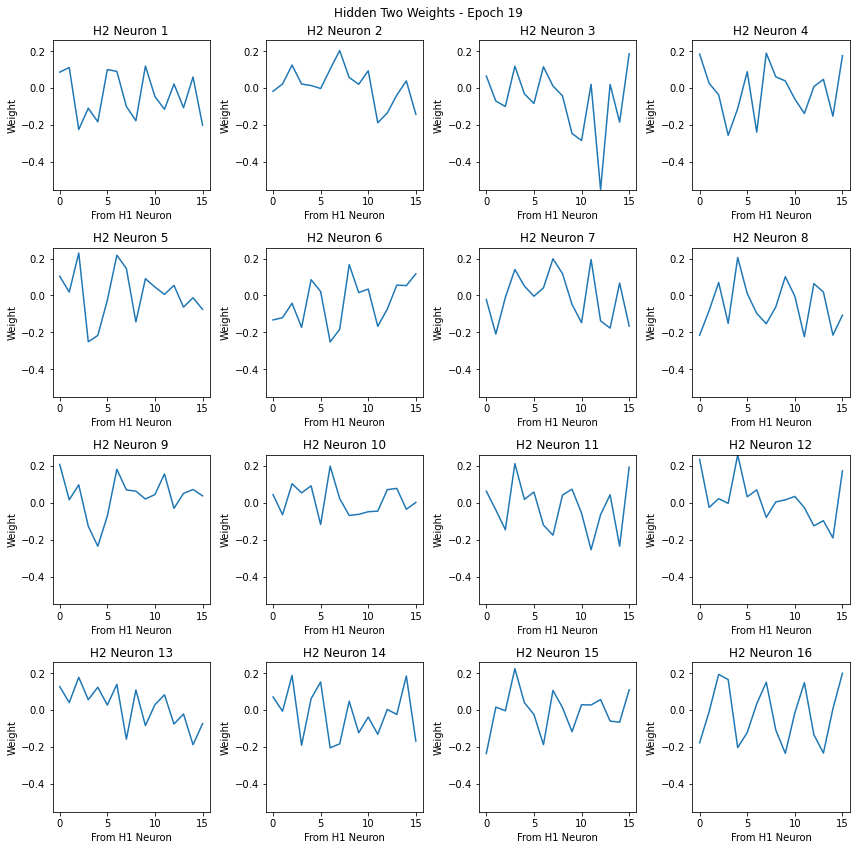

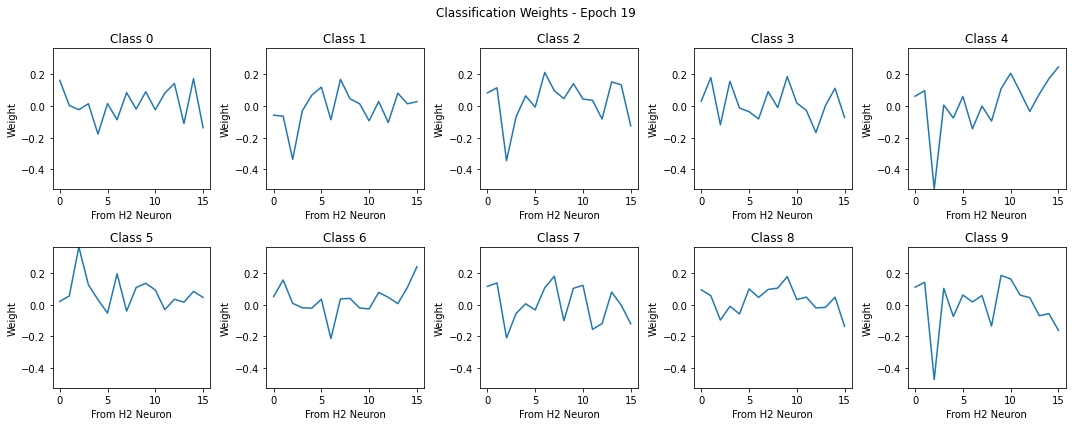

Epoch 20/20
  Train Loss: 0.3108
  SAE Train Loss (hidden one): 1.6115
  SAE Train Loss (hidden two): 0.1136
  Val Loss: 0.3599 | Val Acc: 89.85%


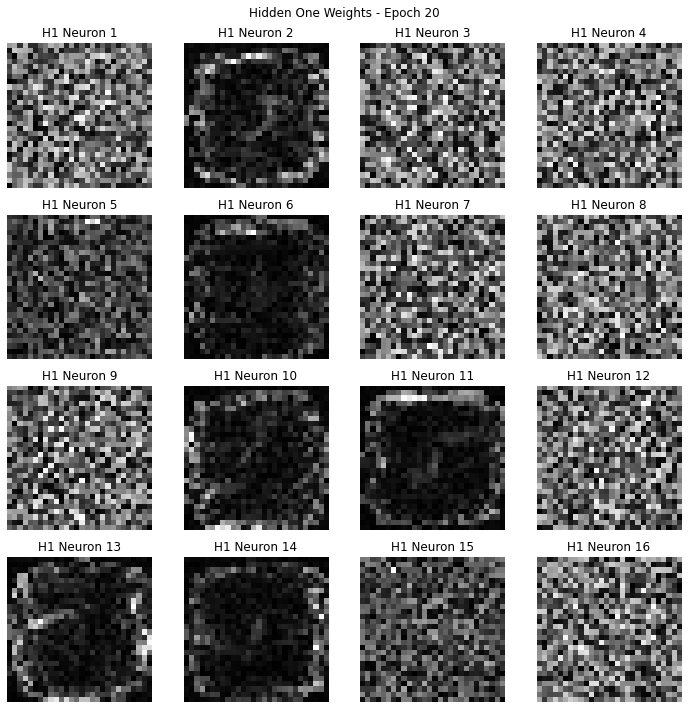

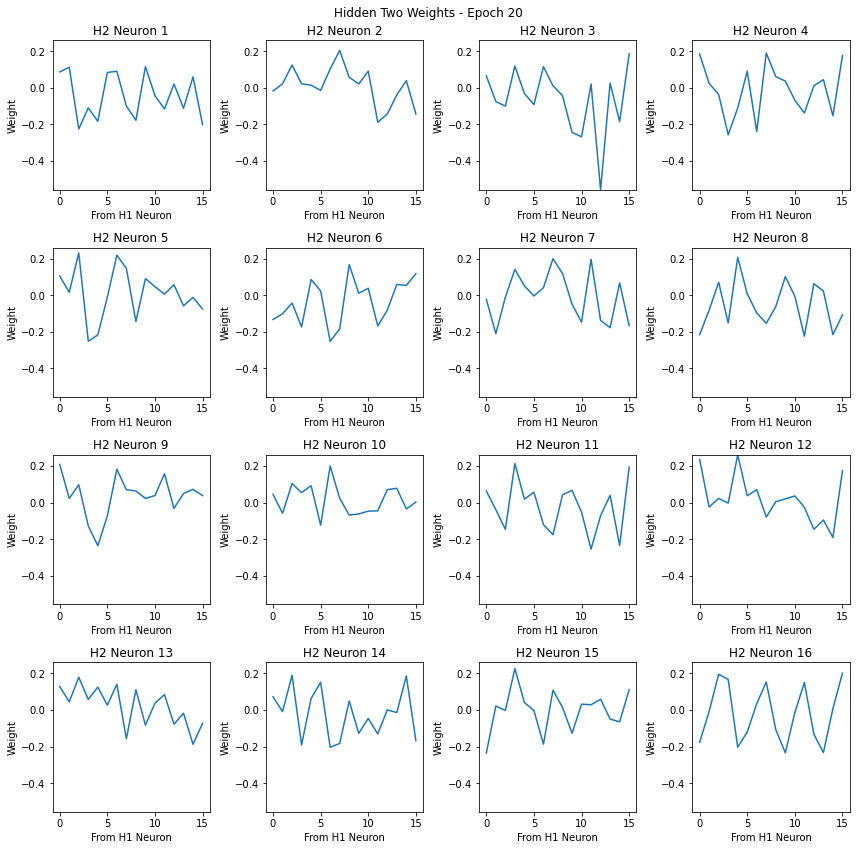

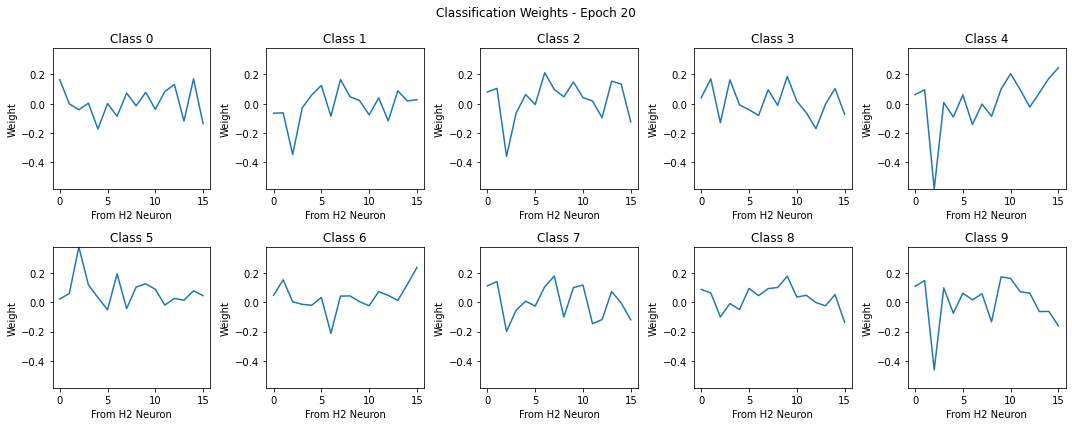

In [23]:
best_model = None
best_sae_one = None
best_sae_two = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    plot_weights(model, epoch, EXPERIMENT_TYPE, RUN_ID)

We have a lot of seemingly dead neurons. Poor for efficiency and likely performance, but also likely messes with out interpretability.

# Training Exploration

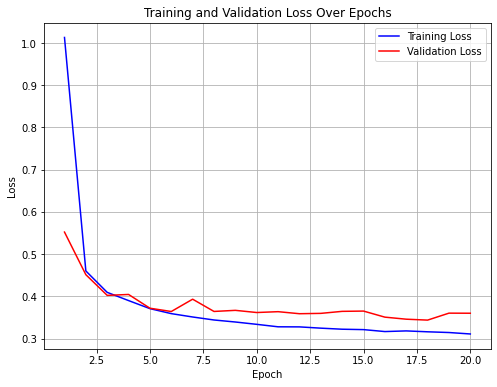

In [24]:
plot_losses(training_losses, validation_losses, label_one="Training", label_two="Validation")

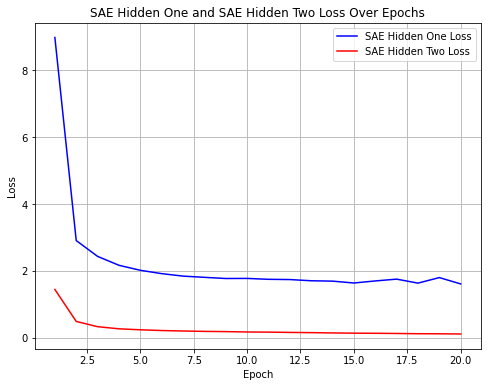

In [25]:
plot_losses(SAE_hidden_one_losses, SAE_hidden_two_losses, 
            label_one="SAE Hidden One", label_two="SAE Hidden Two")

SAEs **still** seem to stop learning really early... again... concerning. At least there is less noise in the training.

## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [26]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
        reconstructed_two, encoded_two = best_sae_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 325.72it/s]

Final Test Accuracy: 90.42%
Average Reconstruction Error (Hidden One): 0.0696
Average Reconstruction Error (Hidden Two): 0.0180
Average Non-Zero Features per Image (Hidden One): 10.77
Average Non-Zero Features per Image (Hidden Two): 6.35


# SAE Feature Exploration

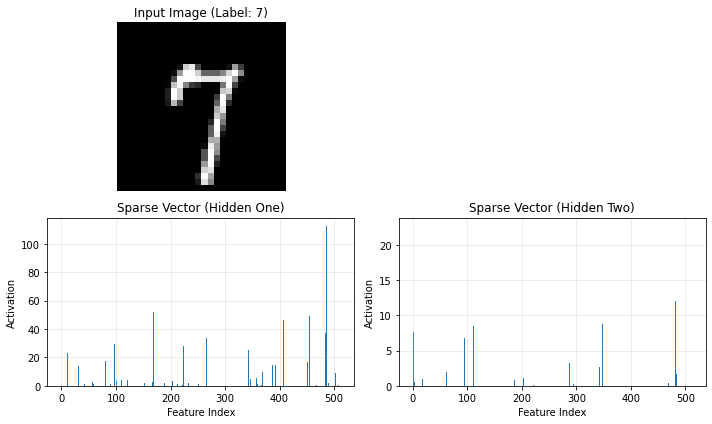

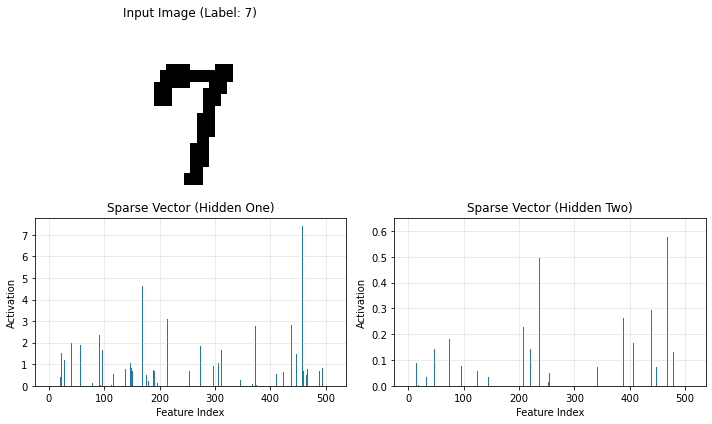

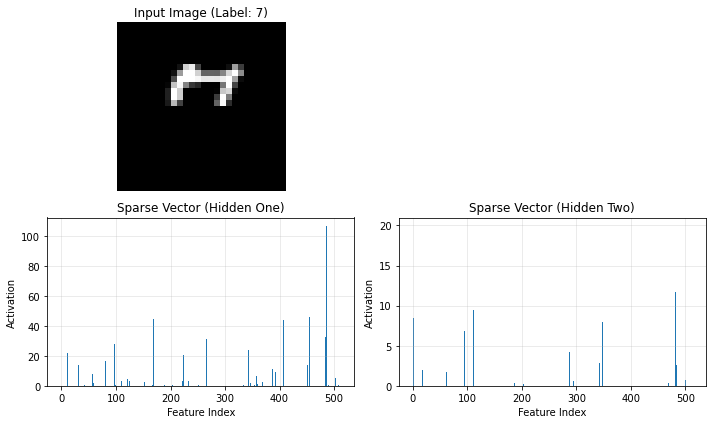

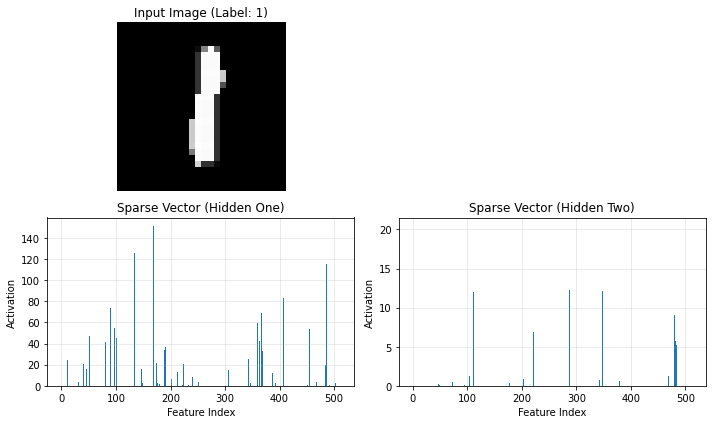

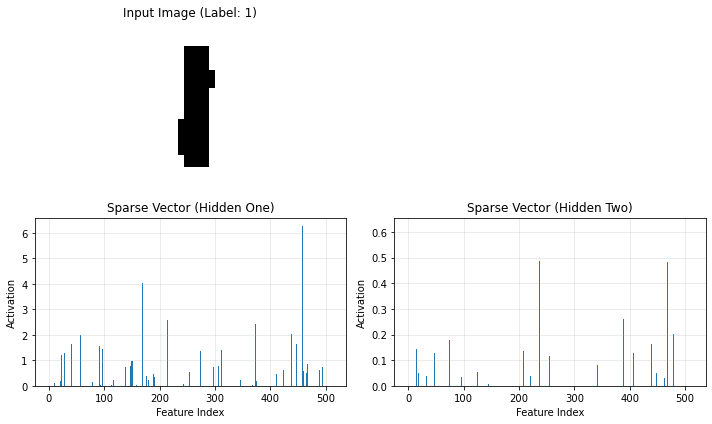

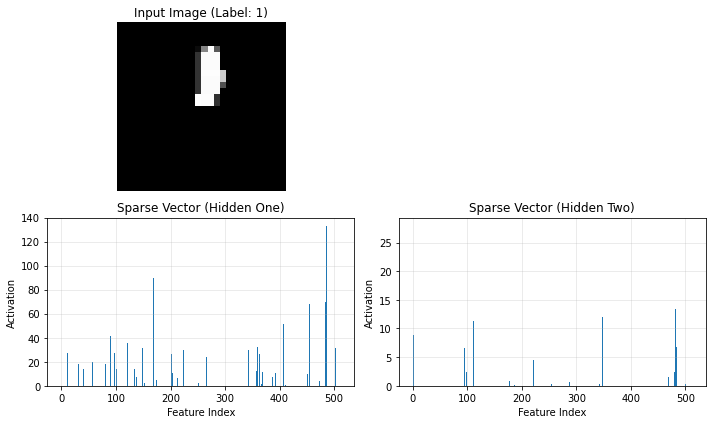

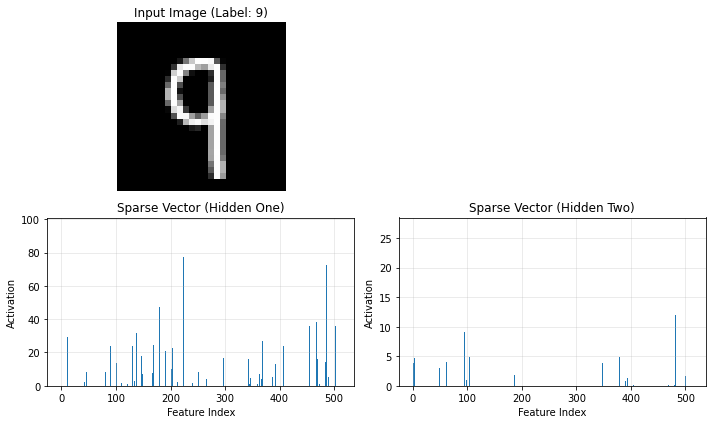

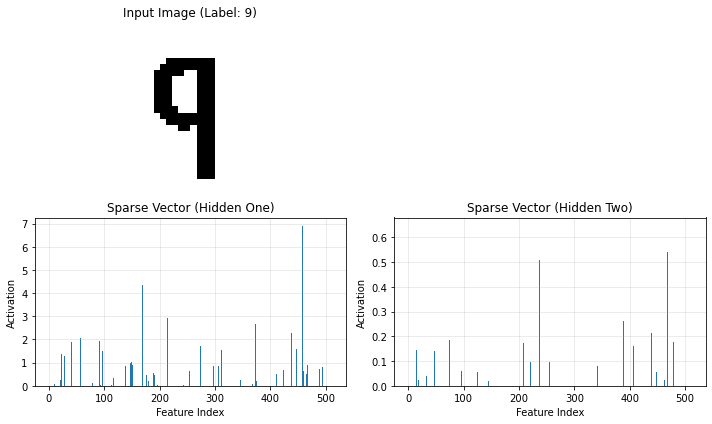

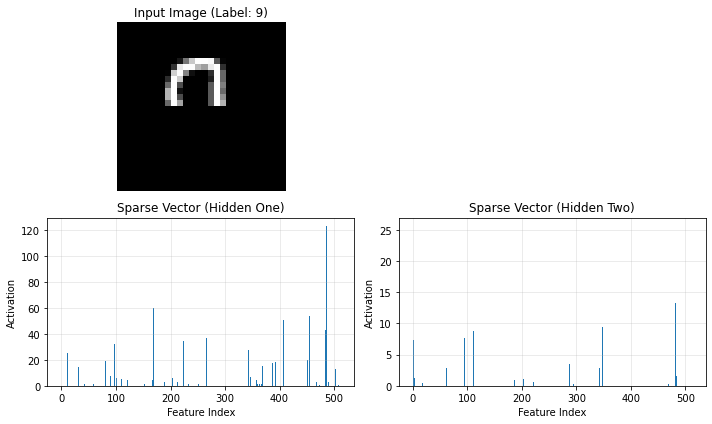

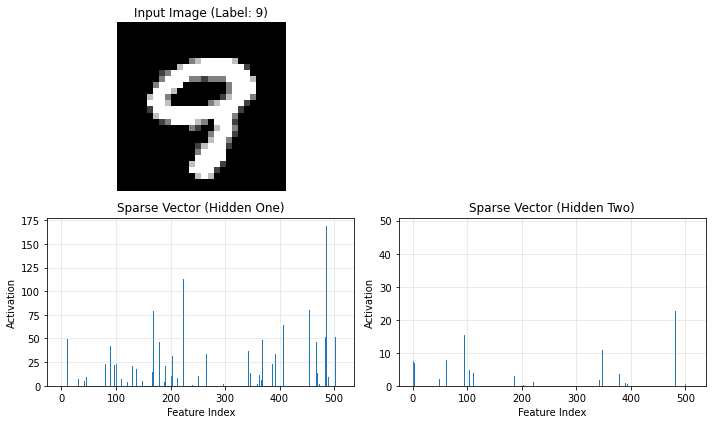

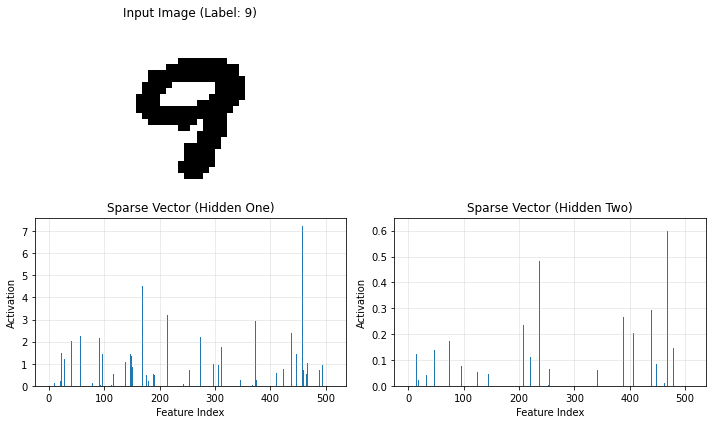

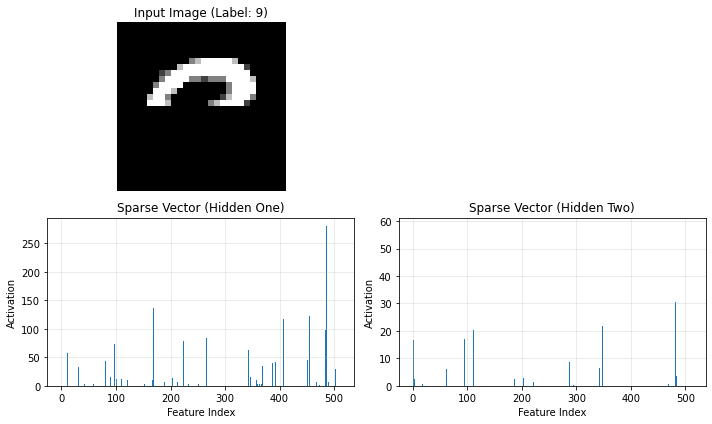

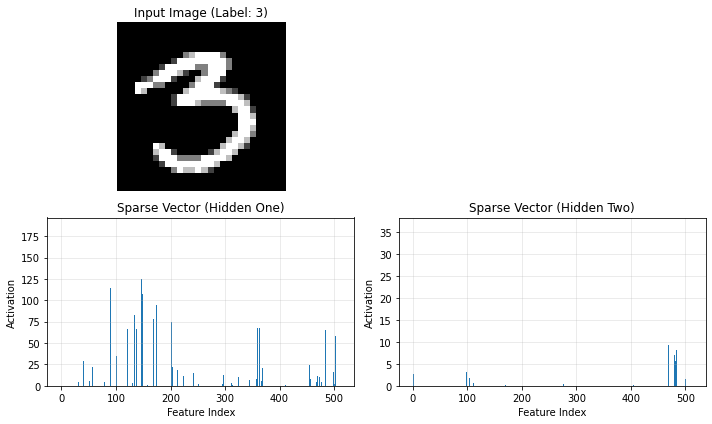

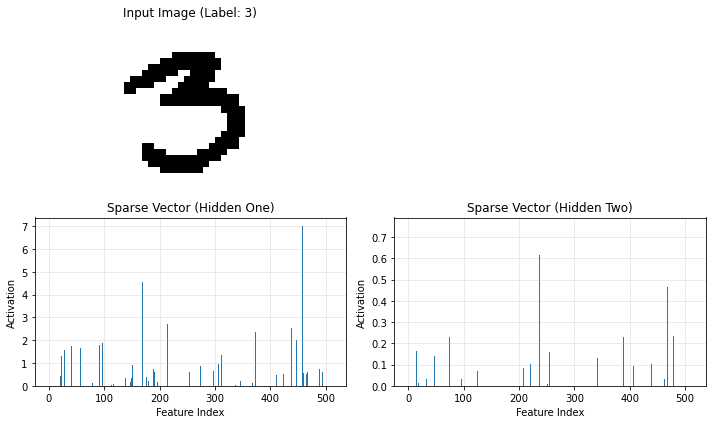

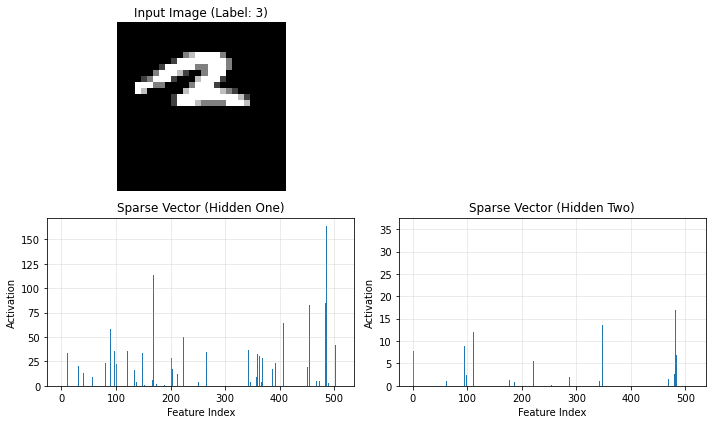

In [38]:
for idx in range(0, 5):
    img, label = train_dataset[idx]
    inverted_img = torch.where(img > 0, torch.zeros_like(img), torch.ones_like(img))

    # Create top-half image
    height, width = img.shape  # Assuming img shape is [C, H, W]
    mask = torch.ones_like(img)  # Initialize mask with ones
    mask[height//2:, :] = 0   # Set bottom half to zero
    top_half_img = img * mask
    
    with torch.no_grad():
        batch_image = img.to(device).unsqueeze(0)  # Shape: [1, C, H, W]
        _, hidden_one_act, hidden_two_act = best_model(batch_image)

        # process inverted image
        batch_inverted_image = inverted_img.to(device).unsqueeze(0)
        _, hidden_one_act_invert, hidden_two_act_invert = best_model(batch_inverted_image)

        # Process top-half image
        batch_top_half_image = top_half_img.to(device).unsqueeze(0)
        _, hidden_one_act_top, hidden_two_act_top = best_model(batch_top_half_image)
    
        # Hidden layer SAEs
        _, encoded_one = best_sae_one(hidden_one_act)
        _, encoded_two = best_sae_two(hidden_two_act)

        # hidden layer SAEs for inverted image
        _, encoded_one_invert = best_sae_one(hidden_one_act_invert)
        _, encoded_two_invert = best_sae_two(hidden_two_act_invert)

        # Hidden layer SAEs for top-half image
        _, encoded_one_top = best_sae_one(hidden_one_act_top)
        _, encoded_two_top = best_sae_two(hidden_two_act_top)
        
        # Squeeze to remove batch dimension and convert to 1D numpy arrays
        encoded_one = encoded_one.squeeze().cpu().numpy()  # Shape: [feature_size]
        encoded_two = encoded_two.squeeze().cpu().numpy()  # Shape: [feature_size]
    
        encoded_one_invert = encoded_one_invert.squeeze().cpu().numpy()
        encoded_two_invert = encoded_two_invert.squeeze().cpu().numpy()

        encoded_one_top = encoded_one_top.squeeze().cpu().numpy()
        encoded_two_top = encoded_two_top.squeeze().cpu().numpy()
    
        plot_sparse_vecs_by_image(img, label, encoded_one, encoded_two)
        plot_sparse_vecs_by_image(inverted_img, label, encoded_one_invert, encoded_two_invert)
        plot_sparse_vecs_by_image(top_half_img, label, encoded_one_top, encoded_two_top)

## Saliency Maps

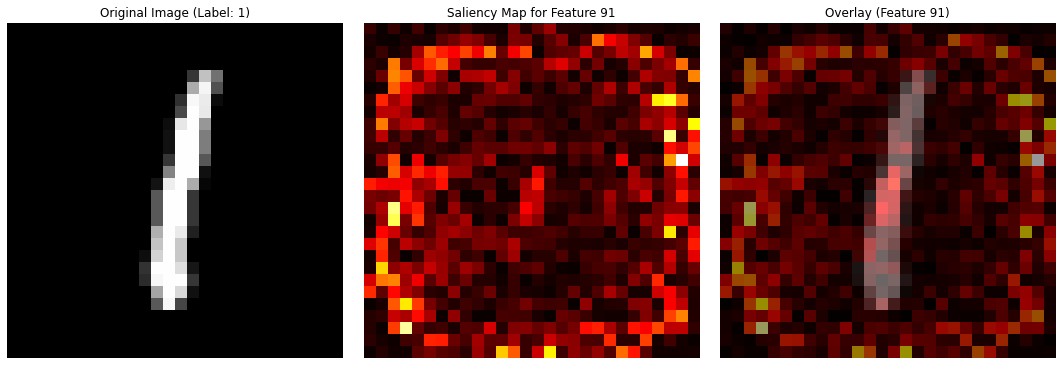

In [32]:
img_idx = 2862
feature_idx = 90
image, label = train_dataset[img_idx]

plot_saliency_map(img_idx, feature_idx, best_model, best_sae_one, train_dataset, HIDDEN_SIZE, device, use_hidden_one=True)

In [33]:
inverted_img = torch.where(image > 0, torch.zeros_like(img), torch.ones_like(img)).numpy()
inverted_img = np.expand_dims(inverted_img, axis=0)
label = np.expand_dims(label.numpy(), axis=0)

train_dataset.images = np.concatenate([train_dataset.images, inverted_img], axis=0)
train_dataset.labels = np.concatenate([train_dataset.labels, label], axis=0)

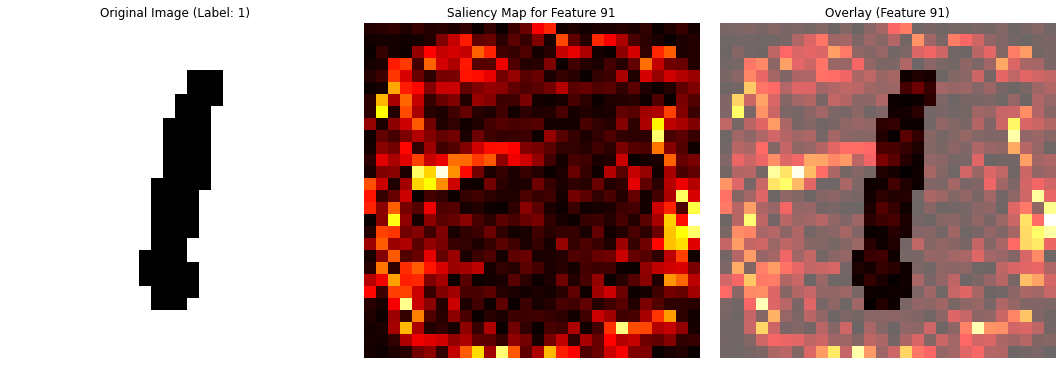

In [35]:
plot_saliency_map(-1, feature_idx, best_model, best_sae_one, train_dataset, HIDDEN_SIZE, device, use_hidden_one=True)